In [25]:
from torchvision.datasets import KMNIST

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.nn.functional as F

import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from torchmetrics import functional as FM

from sklearn.neural_network import MLPClassifier

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix

def plot_confusion_matrix(cm, classes, title, cmap = plt.cm.Blues):
    
    plt.figure(figsize = (15,15))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title, fontsize = 30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment = 'center',
                color = 'red' if cm[i,j] > thresh else "black", fontsize = 30)
        
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Prediction Label')
    plt.show()

# CNN filter 시각화 함수
def show_filter_filter(parameter_path):
    
    parameter = torch.load(parameter_path)['state_dict']
    
    conv1 = parameter['conv1.weight'].detach().cpu().numpy().reshape(1,10,3,3)
    for channel_ind , chanel in enumerate(conv1):
        
        fig = plt.figure(figsize=(20,5))
        plt.title(f'CONV1 filter - type : {chanel_ind}')
        for ind, img in enumerate(chanel):
            ax = fig.add_subplot(2,5,ind+1)
            ax.imshow(img, interpolation='nearest',cmap='gray')
            ax.set_xticks([]), ax.set_yticks([])
            
            for i, j in itertools.product(range(img.shape[0]), range(img.shape[1])):
                plt.text(j, i, round(img[i, j],2),
                horizontalalignment="center",color="red",fontsize=12)
                
    conv2 = parameter['conv2.weight'].detach().cpu().numpy().reshape(20,10,3,3)
    for chanel_ind , chanel in enumerate(conv2):
        
        fig = plt.figure(figsize=(20,5))
        plt.title(f'CONV2 filter - type : {chanel_ind}')
        for ind, img in enumerate(chanel):
            ax = fig.add_subplot(2,5,ind+1)
            ax.imshow(img, interpolation='nearest',cmap='gray')
            ax.set_xticks([]), ax.set_yticks([])
            
            for i, j in itertools.product(range(img.shape[0]), range(img.shape[1])):
                plt.text(j, i, round(img[i, j],2),
                horizontalalignment="center",color="red",fontsize=12)
                
    conv3 = parameter['conv3.weight'].detach().cpu().numpy().reshape(40,20,3,3)
    for chanel_ind , chanel in enumerate(conv3):
        
        fig = plt.figure(figsize=(20,10))
        plt.title(f'CONV3 filter - type : {chanel_ind}')
        for ind, img in enumerate(chanel):
            ax = fig.add_subplot(4,5,ind+1)
            ax.imshow(img, interpolation='nearest',cmap='gray')
            ax.set_xticks([]), ax.set_yticks([])
            
            for i, j in itertools.product(range(img.shape[0]), range(img.shape[1])):
                plt.text(j, i, round(img[i, j],2),
                horizontalalignment="center",color="red",fontsize=12)

    plt.show()

import warnings, itertools, time
warnings.filterwarnings(action = 'ignore')

In [26]:
download_root = './'

In [27]:
k_mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.0,), (1.0,))
])

dataset = KMNIST(download_root, transform = k_mnist_transform, train = True, download = True)
sample, extra=torch.utils.data.random_split(dataset, [6000,54000])

train_dataset, valid_dataset = torch.utils.data.random_split(sample, [5000,1000])

test_dataset = KMNIST(download_root, transform = k_mnist_transform, train = False, download = True)
testdata, ext=torch.utils.data.random_split(test_dataset, [1000,9000])

test_dataset=testdata

In [28]:
train_loader = DataLoader(train_dataset,batch_size = 100)
valid_loader = DataLoader(valid_dataset,batch_size = 100)
test_loader = DataLoader(test_dataset,batch_size = 100)

In [25]:
class CNN(pl.LightningModule):
    def __init__(self, class_num):
        super().__init__()
        
        #convolution
        self.conv1 = nn.Conv2d(1,10,(3,3))
        self.conv2 = nn.Conv2d(10,20,(3,3))
        self.conv3 = nn.Conv2d(20,40,(3,3))
        
        #pooling layer
        self.max_pool = nn.MaxPool2d((2,2),2)
        
        #dropout
        self.dropout_1 = nn.Dropout(p=0.3)
        self.dropout_2 = nn.Dropout(p=0.1)
        
        #activation function
        self.relu = nn.ReLU(inplace=True)
        self.lrelu = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        
        #classifier
        self.classifier = nn.Sequential(nn.Linear(500, 300),
                                       self.relu,
                                       self.dropout_1,
                                       nn.Linear(300,100),
                                       self.lrelu,
                                       self.dropout_2,
                                       nn.Linear(100, class_num))
        
        #for logging
        self.train_loss_ = []
        self.train_acc_ = []
        self.val_loss_ = []
        self.val_acc_ = []
        
        #for convenient
        self.class_num = class_num
        
    def forward(self, x): #x is input data
        
        # x -> convolution -> relu -> max_pool -> dropout
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool(x)
        x = self.dropout_1(x)
        
        # .. -> convolution -> relu -> max_pool -> dropout
        x = self.conv2(x)
        x = self.lrelu(x)
        x = self.max_pool(x)
        x = self.dropout_2(x)
        
        # .. -> classifier - logit
        flatten = x.view(x.size(0),-1)
        logit = self.classifier(flatten)
        
        return logit
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters() , lr = 0.001)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logit = self(x)
        prob = F.softmax(logit, dim=1)
        train_accuracy = FM.accuracy(prob,y)
        loss = F.cross_entropy(logit,y)
        logs = {'train_loss':loss, 'train_acc':train_accuracy}
        result = {'loss':loss, 'log':logs, 'train_acc':train_accuracy}
        return result
    
    def training_epoch_end(self,result):
        avg_loss = torch.stack([x['loss'] for x in result]).mean()
        avg_acc = torch.stack([x['train_acc'] for x in result]).mean()
        global cn_train_epoch_result
        cn_train_epoch_result = {'loss': avg_loss, 'train_acc': avg_acc}
        self.train_loss_.append(avg_loss.cpu().numpy().item())
        self.train_acc_.append(avg_acc.cpu().numpy().item())
        
    
    def validation_step(self,batch,batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat_prob = F.softmax(y_hat,dim=1)
        val_accuracy = FM.accuracy(y_hat_prob,y)
        val_loss = F.cross_entropy(y_hat,y)
        logs = {'val_accuracy':val_accuracy,'val_loss':val_loss}
        result = {'loss':val_loss,'log':logs,'val_acc':val_accuracy}
        return result
    
    def validation_epoch_end(self,result):
        avg_loss = torch.stack([x['loss'] for x in result]).mean()
        avg_acc = torch.stack([x['val_acc'] for x in result]).mean()
        epoch_result = {'loss':avg_loss,'acc':avg_acc}
        self.val_loss_.append(avg_loss.cpu().numpy().item())
        self.val_acc_.append(avg_acc.cpu().numpy().item())
        self.log('val_accuracy',avg_acc)
        return epoch_result
    
    def test_step(self,batch,batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat_prob = F.softmax(y_hat,dim=1)
        result = {'predicted':y_hat_prob,'target':y}
        return result
    
    def test_epoch_end(self,result):
        
        predicted = torch.stack([x['predicted'] for x in result])
        predicted = predicted.view(-1,self.class_num)
        target = torch.stack([x['target'] for x in result])
        target = target.view(-1)
        
        self.test_predicted = predicted.detach().cpu().numpy()
        self.test_target = target.detach().cpu().numpy()
        

In [26]:
class DNN(pl.LightningModule):
    def __init__(self, class_num):
        super().__init__()
        
        #dropout
        self.dropout_1 = nn.Dropout(p=0.3)
        self.dropout_2 = nn.Dropout(p=0.1)
        
        #activation function
        self.relu = nn.ReLU(inplace=True)
        self.lrelu = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        
        #classifier
        self.classifier = nn.Sequential(nn.Linear(28*28, 300),
                                       self.relu,
                                       self.dropout_1,
                                       nn.Linear(300,100),
                                       self.lrelu,
                                       self.dropout_2,
                                       nn.Linear(100, class_num))
        
        #for logging
        self.train_loss_ = []
        self.train_acc_ = []
        self.val_loss_ = []
        self.val_acc_ = []
        
        #for convenient
        self.class_num = class_num
        
    def forward(self, x): #x is input data
        
        # .. -> classifier - logit
        flatten = x.view(x.size(0),-1)
        logit = self.classifier(flatten)
        
        return logit
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters() , lr = 0.001)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logit = self(x)
        prob = F.softmax(logit, dim=1)
        train_accuracy = FM.accuracy(prob,y)
        loss = F.cross_entropy(logit,y)
        logs = {'train_loss':loss, 'train_acc':train_accuracy}
        result = {'loss':loss, 'log':logs, 'train_acc':train_accuracy}
        return result
    
    def training_epoch_end(self,result):
        avg_loss = torch.stack([x['loss'] for x in result]).mean()
        avg_acc = torch.stack([x['train_acc'] for x in result]).mean()
        global dn_train_epoch_result
        dn_train_epoch_result = {'loss': avg_loss, 'train_acc': avg_acc}
        self.train_loss_.append(avg_loss.cpu().numpy().item())
        self.train_acc_.append(avg_acc.cpu().numpy().item())
    
    def validation_step(self,batch,batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat_prob = F.softmax(y_hat,dim=1)
        val_accuracy = FM.accuracy(y_hat_prob,y)
        val_loss = F.cross_entropy(y_hat,y)
        logs = {'val_accuracy':val_accuracy,'val_loss':val_loss}
        result = {'loss':val_loss,'log':logs,'val_acc':val_accuracy}
        return result
    
    def validation_epoch_end(self,result):
        avg_loss = torch.stack([x['loss'] for x in result]).mean()
        avg_acc = torch.stack([x['val_acc'] for x in result]).mean()
        epoch_result = {'loss': avg_loss,'acc': avg_acc}
        self.val_loss_.append(avg_loss.cpu().numpy().item())
        self.val_acc_.append(avg_acc.cpu().numpy().item())
        self.log('val_accuracy',avg_acc)
        return epoch_result
    
    def test_step(self,batch,batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat_prob = F.softmax(y_hat,dim=1)
        result = {'predicted':y_hat_prob,'target':y}
        return result
    
    def test_epoch_end(self,result):
        
        predicted = torch.stack([x['predicted'] for x in result])
        predicted = predicted.view(-1,self.class_num)
        target = torch.stack([x['target'] for x in result])
        target = target.view(-1)
        
        self.test_predicted = predicted.detach().cpu().numpy()
        self.test_target = target.detach().cpu().numpy()
        

# 모델학습

## CNN

In [27]:
start = time.time()
cnn = CNN(class_num=10)
early_stop = EarlyStopping(monitor='val_accuracy',patience=5,verbose=True,mode='max') #Early stopping
checkpoint = ModelCheckpoint(filename='./CNN-{epoch}-{val_accuracy}',monitor='val_accuracy',mode='max',save_top_k=1) #mode
trainer = pl.Trainer(callbacks=[early_stop,checkpoint],gpus=0)
trainer.fit(cnn,train_loader,valid_loader)
print("time :", time.time() - start) #학습소요시간 출력

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | conv1      | Conv2d     | 100   
1 | conv2      | Conv2d     | 1.8 K 
2 | conv3      | Conv2d     | 7.2 K 
3 | max_pool   | MaxPool2d  | 0     
4 | dropout_1  | Dropout    | 0     
5 | dropout_2  | Dropout    | 0     
6 | relu       | ReLU       | 0     
7 | lrelu      | LeakyReLU  | 0     
8 | classifier | Sequential | 181 K 
------------------------------------------
190 K     Trainable params
0         Non-trainable params
190 K     Total params
0.762     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved. New best score: 0.627


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.138 >= min_delta = 0.0. New best score: 0.765


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.047 >= min_delta = 0.0. New best score: 0.812


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.031 >= min_delta = 0.0. New best score: 0.843


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.023 >= min_delta = 0.0. New best score: 0.866


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.021 >= min_delta = 0.0. New best score: 0.887


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.008 >= min_delta = 0.0. New best score: 0.895


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.897


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.009 >= min_delta = 0.0. New best score: 0.906


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.012 >= min_delta = 0.0. New best score: 0.918


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.005 >= min_delta = 0.0. New best score: 0.923


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.005 >= min_delta = 0.0. New best score: 0.928


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.929


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.008 >= min_delta = 0.0. New best score: 0.937


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.007 >= min_delta = 0.0. New best score: 0.944


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.947


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.951


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_accuracy did not improve in the last 5 records. Best score: 0.951. Signaling Trainer to stop.


time : 138.9573848247528


In [28]:
cn_train_epoch_result

{'loss': tensor(0.1023), 'train_acc': tensor(0.9680)}

## DNN

In [29]:
start = time.time()
dnn = DNN(class_num=10)
early_stop = EarlyStopping(monitor='val_accuracy',patience=5,verbose=True,mode='max') #Early stopping
checkpoint = ModelCheckpoint(filename='./DNN-{epoch}-{val_accuracy}',monitor='val_accuracy',mode='max',save_top_k=1) #mode
trainer = pl.Trainer(callbacks=[early_stop,checkpoint],gpus=0)
trainer.fit(dnn,train_loader,valid_loader)
print("time :", time.time() - start) #학습소요시간 출력

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | dropout_1  | Dropout    | 0     
1 | dropout_2  | Dropout    | 0     
2 | relu       | ReLU       | 0     
3 | lrelu      | LeakyReLU  | 0     
4 | classifier | Sequential | 266 K 
------------------------------------------
266 K     Trainable params
0         Non-trainable params
266 K     Total params
1.066     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved. New best score: 0.727


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.089 >= min_delta = 0.0. New best score: 0.816


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.020 >= min_delta = 0.0. New best score: 0.836


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.019 >= min_delta = 0.0. New best score: 0.855


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.011 >= min_delta = 0.0. New best score: 0.866


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.010 >= min_delta = 0.0. New best score: 0.876


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.007 >= min_delta = 0.0. New best score: 0.883


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.007 >= min_delta = 0.0. New best score: 0.890


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.892


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.895


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.897


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.899


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.902


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_accuracy did not improve in the last 5 records. Best score: 0.902. Signaling Trainer to stop.


time : 87.58853936195374


## 학습 현황 확인 및 예측 결과 출력

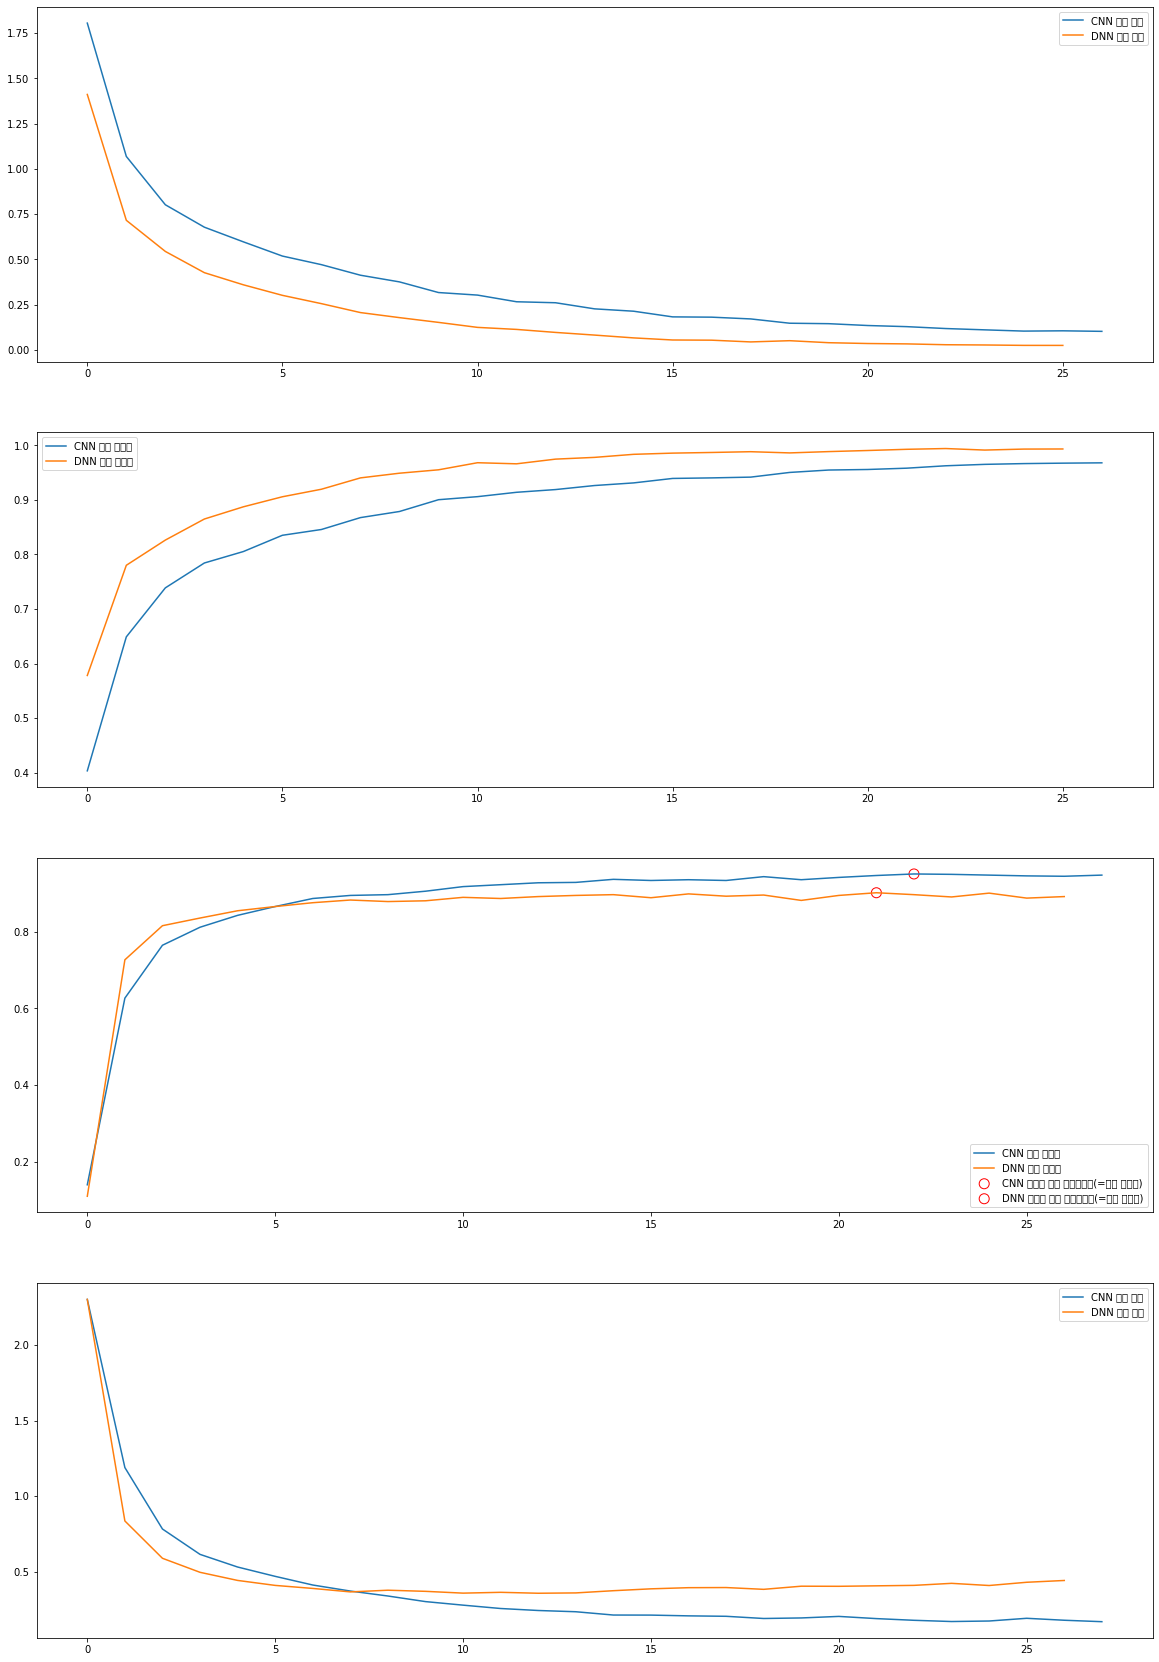

In [35]:
# CNN logs
cnn_train_loss = cnn.train_loss_
cnn_train_acc = cnn.train_acc_
cnn_valid_loss = cnn.val_loss_
cnn_valid_acc = cnn.val_acc_

#DNN logs
dnn_train_loss = dnn.train_loss_
dnn_train_acc = dnn.train_acc_
dnn_valid_loss = dnn.val_loss_
dnn_valid_acc = dnn.val_acc_

#그래프 배경화면 만들기
f, axs = plt.subplots(4,1,figsize=(20,30))

#학습로스 변동 관찰하기
axs[0].plot(cnn_train_loss,label='CNN 학습 로스')
axs[0].plot(dnn_train_loss,label='DNN 학습 로스')
axs[0].legend()

#학습 정확도 변동 관찰하기
axs[1].plot(cnn_train_acc,label='CNN 학습 정확도')
axs[1].plot(dnn_train_acc,label='DNN 학습 정확도')
axs[1].legend()

#검증용 데이터에 대한 accuracy 변동 관찰하기
axs[2].plot(cnn_valid_acc,label='CNN 검증 정확도')
axs[2].scatter(np.argmax(cnn_valid_acc),np.max(cnn_valid_acc),s=100,facecolors='none',edgecolors='r',label='CNN 최적의 학습 체크포인트(=학습 중단점)')
axs[2].plot(dnn_valid_acc,label='DNN 검증 정확도')
axs[2].scatter(np.argmax(dnn_valid_acc),np.max(dnn_valid_acc),s=100,facecolors='none',edgecolors='r',label='DNN 최적의 학습 체크포인트(=학습 중단점)')
axs[2].legend()

#검증용 데이터에 대한 loss 변동 관찰하기
axs[3].plot(cnn_valid_loss,label='CNN 검증 로스')
axs[3].plot(dnn_valid_loss,label='DNN 검증 로스')
axs[3].legend()

plt.show()

In [37]:
np.argmax(cnn_valid_acc), np.argmax(dnn_valid_acc)

(22, 21)

In [31]:
# Test accuracy 확인

trainer.test(model=cnn, dataloaders=test_loader)
trainer.test(model=dnn, dataloaders=test_loader)

cnn_test_accuracy = accuracy_score(y_pred=cnn.test_predicted.argmax(1),y_true=cnn.test_target)
dnn_test_accuracy = accuracy_score(y_pred=dnn.test_predicted.argmax(1),y_true=dnn.test_target)
print(f"CNN 분류 정확도: {cnn_test_accuracy:.3f}",f"DNN 분류 정확도: {dnn_test_accuracy:.3f}",sep=' l ')

Testing: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

CNN 분류 정확도: 0.869 l DNN 분류 정확도: 0.792


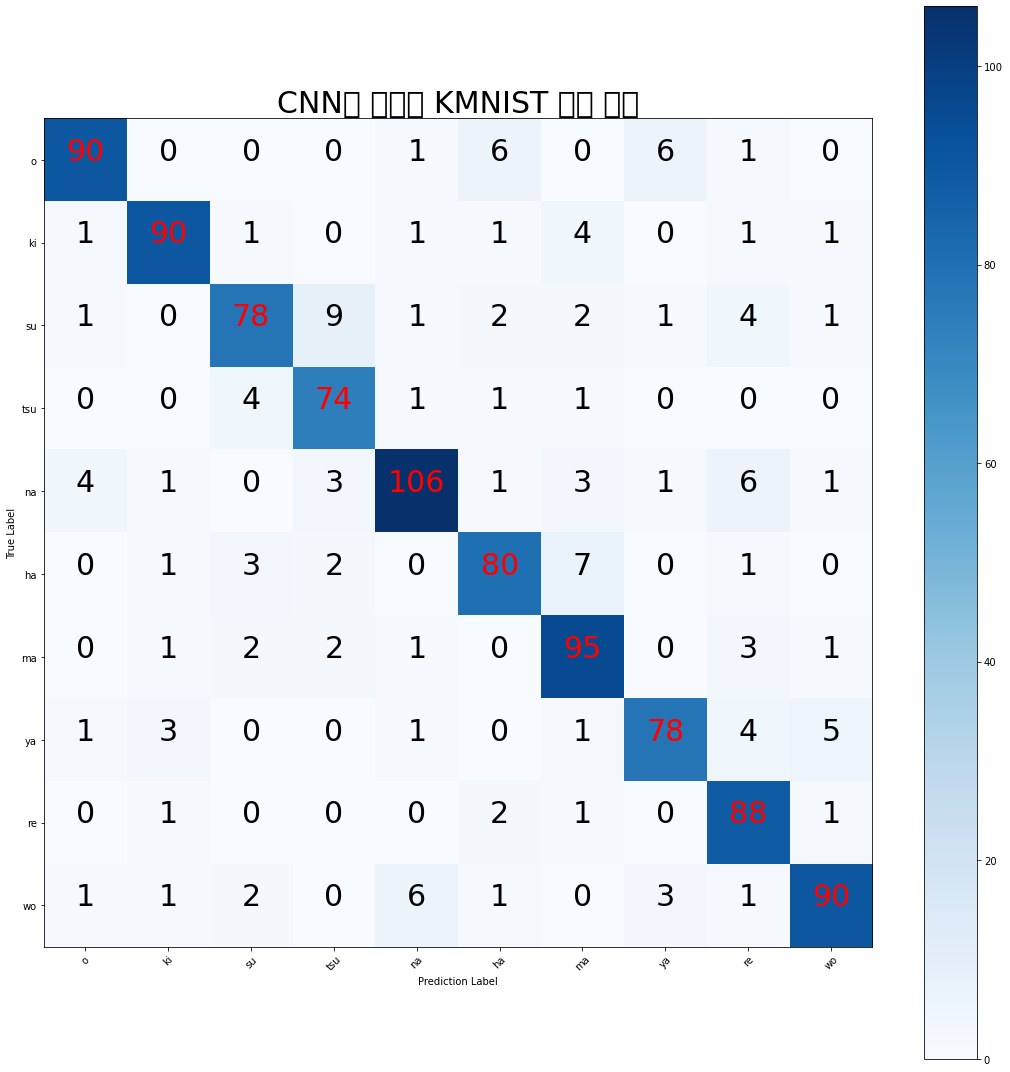

In [32]:
confusion_matrix_ = confusion_matrix(y_pred=cnn.test_predicted.argmax(1),y_true=cnn.test_target)
plot_confusion_matrix(cm = confusion_matrix_, classes=dataset.classes,title='CNN을 이용한 KMNIST 예측 결과')

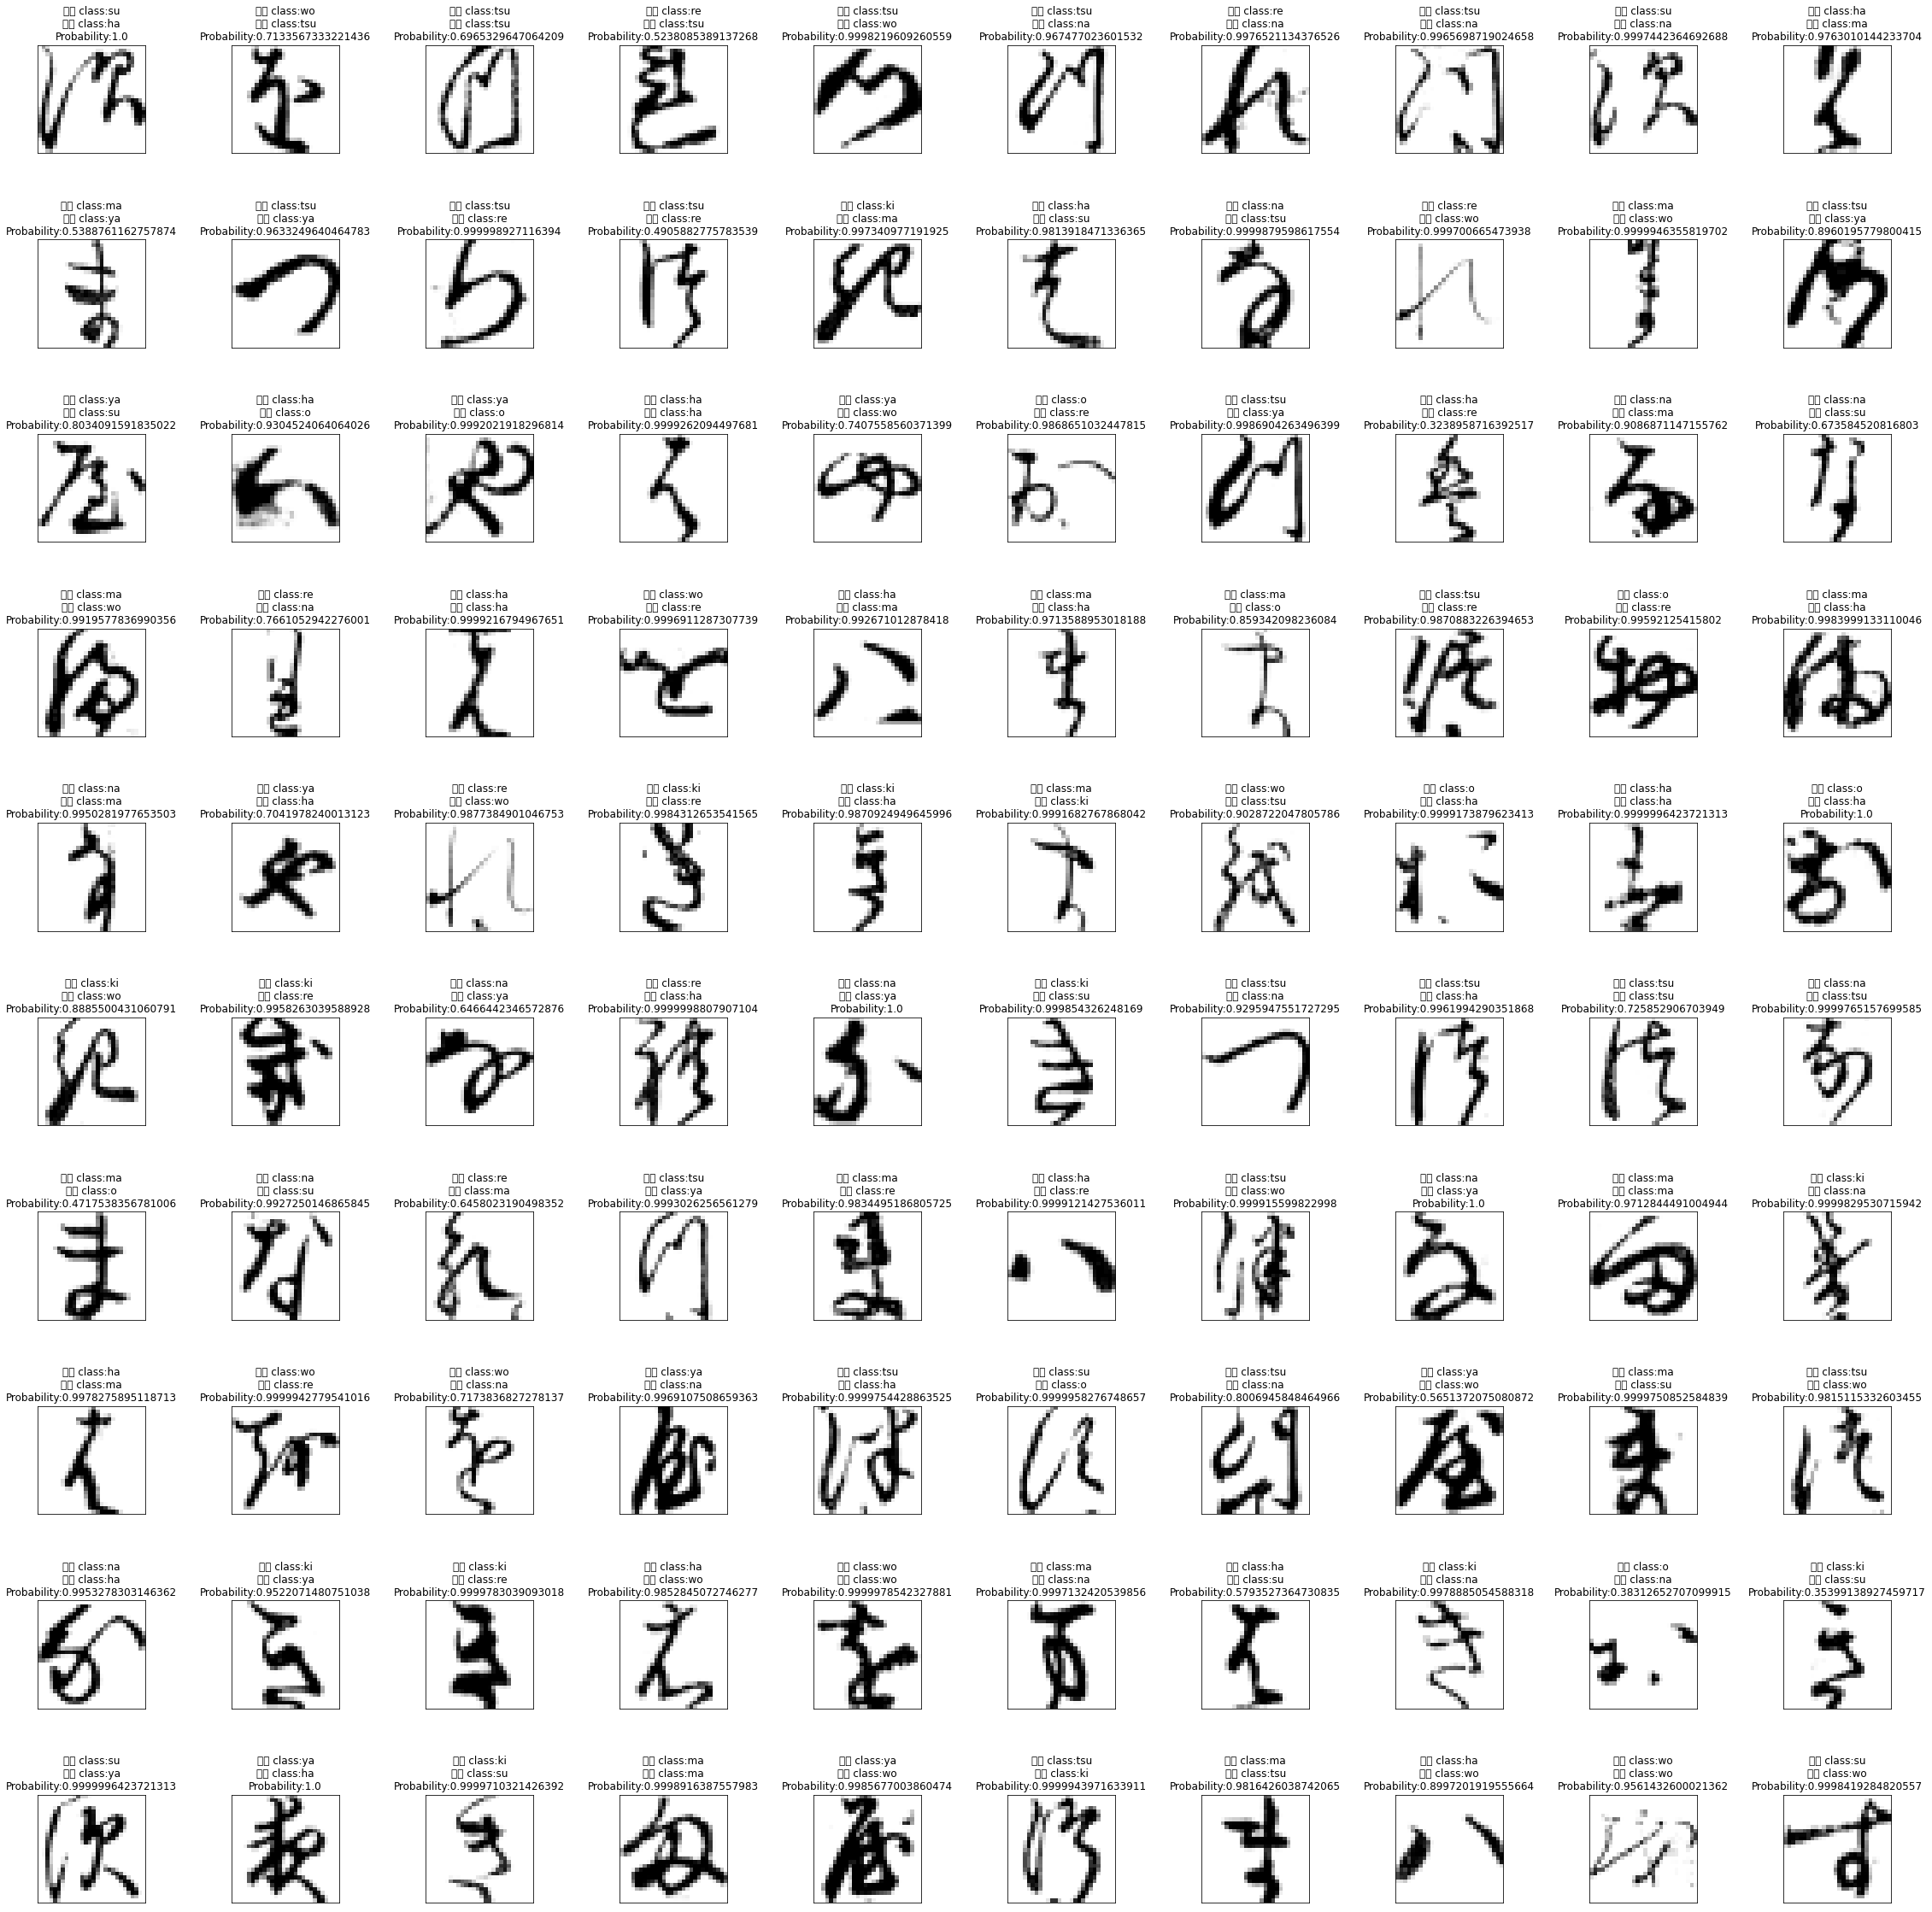

In [40]:
for_visualization_test_x = test_dataset.data.numpy()[:100]
for_visualization_test_y = test_dataset.targets.numpy()[:100]

f, axs = plt.subplots(10, 10, figsize=(40,40))
plt.subplots_adjust(hspace=0.8)
for i in range(10):
    for j in range(10):
        
        x_data = for_visualization_test_x[10*i+j]
        y_data = for_visualization_test_y[10*i+j]
        real_class = dataset.classes[y_data]
        predicted_class = dataset.classes[cnn.test_predicted[10*i+j].argmax()]
        predicted_prob = cnn.test_predicted[10*i+j].max()
        
        # x, y축의 지점 표시를 안함
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        
        # subplot의 제목을 i번째 결과에 해당하는 숫자로 설정
        axs[i,j].set_title(f"실제 class:{real_class}\n예측 class:{predicted_class}\nProbability:{predicted_prob}")
        
        # 입력으로 사용한 i번째 테스트 이미지를 28X28로 재배열하고
        # 이 2차원 배열을 그레이스케일 이미지로 출력
        axs[i,j].imshow(x_data.reshape((28, 28)), cmap=plt.cm.gray_r)
        
plt.show()

In [41]:
test_dataset

Dataset KMNIST
    Number of datapoints: 10000
    Root location: ./
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.0,), std=(1.0,))
           )

In [14]:
parameter_path = "./lightning_logs/version_11/checkpoints/CNN-epoch=34-val_accuracy=0.9134000539779663.ckpt"
show_filter_filter(parameter_path)

FileNotFoundError: [Errno 2] No such file or directory: './lightning_logs/version_11/checkpoints/CNN-epoch=34-val_accuracy=0.9134000539779663.ckpt'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image as pil_image
import cv2

import glob

import tensorflow as tf
from tensorflow.python.keras.models import model_from_json
from tensorflow.python.keras import backend as K
from tensorflow.python.framework import ops


import scipy
from scipy import ndimage
from skimage.measure import label, regionprops

%matplotlib inline

In [1]:
!pip install tensorflow

  Using cached tensorflow-2.9.1-cp39-cp39-win_amd64.whl (444.0 MB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Using cached tensorflow_io_gcs_filesystem-0.26.0-cp39-cp39-win_amd64.whl (1.5 MB)
  Using cached tensorflow_estimator-2.9.0-py2.py3-none-any.whl (438 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached termcolor-1.1.0-py3-none-any.whl
  Using cached libclang-14.0.1-py2.py3-none-win_amd64.whl (14.2 MB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached keras-2.9.0-py2.py3-none-any.whl (1.6 MB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)

In [3]:
def generate_cam(img_tensor, model, class_index, activation_layer):
    """
    params:
    -------
    img_tensor: resnet50 모델의 이미지 전처리를 통한 image tensor
    model: pretrained resnet50 모델 (include_top=True)
    class_index: 이미지넷 정답 레이블
    activation_layer: 시각화하려는 레이어 이름

    return:
    cam: cam 히트맵
    """
    inp = model.input
    A_k = model.get_layer(activation_layer).output
    outp = model.layers[-1].output

    ## 이미지 텐서를 입력해서
    ## 해당 액티베이션 레이어의 아웃풋(a_k)과
    ## 소프트맥스 함수 인풋의 a_k에 대한 gradient를 구한다.
    get_output = K.function([inp], [A_k, outp])
    [conv_output, predictions] = get_output([img_tensor])
    
    ## 배치 사이즈가 1이므로 배치 차원을 없앤다.
    conv_output = conv_output[0]
    
    ## 마지막 소프트맥스 레이어의 웨이트 매트릭스에서
    ## 지정한 레이블에 해당하는 횡벡터만 가져온다.
    weights = model.layers[-1].get_weights()[0][:, class_index]
    
    ## 추출한 conv_output에 weight를 곱하고 합하여 cam을 얻는다.
    cam = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        cam += w * conv_output[:, :, k]
    
    cam = cv2.resize(cam, (224, 224))
    cam = cam / cam.max()
    
    return cam

In [4]:
cam = generate_cam()

TypeError: generate_cam() missing 4 required positional arguments: 'img_tensor', 'model', 'class_index', and 'activation_layer'

In [5]:
JSON_PATH = "resnet_CAM_new.json"
H5_PATH = "resnet_CAM_new.h5"

In [6]:
def load_model(json_path, h5_path):
    with open(json_path, "r") as f:
        loaded_model_json = f.read()
    
    tl_model = model_from_json(loaded_model_json)
    tl_model.load_weights(h5_path)
    
    return tl_model

In [8]:
def generate_cam(model, img_path, class_idx):
    
    ## img_path -> preprocessed image tensor
    img_arr, img_tensor = preprocess_input(img_path)
    
    ## preprocessed image tensor -> last_conv_output, predictions
    get_output = K.function([model.layers[0].input], [model.layers[-4].output, model.layers[-1].output])
    [conv_outputs, predictions] = get_output([img_tensor])
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0]
    
    ## generate cam
    cam = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        cam += w * conv_outputs[:, :, i]
        
    cam /= np.max(cam)
    cam = cv2.resize(cam, (224, 224))
    
    return img_arr, cam, predictions    

In [42]:
class CNN(pl.LightningModule):
    def __init__(self, class_num):
        super().__init__()
        
        #convolution
        self.conv1 = nn.Conv2d(1,10,(3,3))
        self.conv2 = nn.Conv2d(10,20,(3,3))
        
        
        #pooling layer
        self.max_pool = nn.MaxPool2d((2,2),2)
        
        #dropout
        self.dropout_1 = nn.Dropout(p=0.3)
        self.dropout_2 = nn.Dropout(p=0.1)
        
        #activation function
        self.relu = nn.ReLU(inplace=True)
        self.lrelu = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        
        #classifier
        self.classifier = nn.Sequential(nn.Linear(500, 300),
                                       self.relu,
                                       self.dropout_1,
                                       nn.Linear(300,100),
                                       self.lrelu,
                                       self.dropout_2,
                                       nn.Linear(100, class_num))
        
        #for logging
        self.train_loss_ = []
        self.train_acc_ = []
        self.val_loss_ = []
        self.val_acc_ = []
        
        #for convenient
        self.class_num = class_num
        
    def forward(self, x): #x is input data
        
        # x -> convolution -> relu -> max_pool -> dropout
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool(x)
        x = self.dropout_1(x)
        
        # .. -> convolution -> relu -> max_pool -> dropout
        x = self.conv2(x)
        x = self.lrelu(x)
        x = self.max_pool(x)
        x = self.dropout_2(x)
        
        # .. -> classifier - logit
        flatten = x.view(x.size(0),-1)
        logit = self.classifier(flatten)
        
        return logit
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters() , lr = 0.001)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logit = self(x)
        prob = F.softmax(logit, dim=1)
        train_accuracy = FM.accuracy(prob,y)
        loss = F.cross_entropy(logit,y)
        logs = {'train_loss':loss, 'train_acc':train_accuracy}
        result = {'loss':loss, 'log':logs, 'train_acc':train_accuracy}
        return result
    
    def training_epoch_end(self,result):
        avg_loss = torch.stack([x['loss'] for x in result]).mean()
        avg_acc = torch.stack([x['train_acc'] for x in result]).mean()
        global cn_train_epoch_result
        cn_train_epoch_result = {'loss': avg_loss, 'train_acc': avg_acc}
        self.train_loss_.append(avg_loss.cpu().numpy().item())
        self.train_acc_.append(avg_acc.cpu().numpy().item())
        
    
    def validation_step(self,batch,batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat_prob = F.softmax(y_hat,dim=1)
        val_accuracy = FM.accuracy(y_hat_prob,y)
        val_loss = F.cross_entropy(y_hat,y)
        logs = {'val_accuracy':val_accuracy,'val_loss':val_loss}
        result = {'loss':val_loss,'log':logs,'val_acc':val_accuracy}
        return result
    
    def validation_epoch_end(self,result):
        avg_loss = torch.stack([x['loss'] for x in result]).mean()
        avg_acc = torch.stack([x['val_acc'] for x in result]).mean()
        epoch_result = {'loss':avg_loss,'acc':avg_acc}
        self.val_loss_.append(avg_loss.cpu().numpy().item())
        self.val_acc_.append(avg_acc.cpu().numpy().item())
        self.log('val_accuracy',avg_acc)
        return epoch_result
    
    def test_step(self,batch,batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat_prob = F.softmax(y_hat,dim=1)
        result = {'predicted':y_hat_prob,'target':y}
        return result
    
    def test_epoch_end(self,result):
        
        predicted = torch.stack([x['predicted'] for x in result])
        predicted = predicted.view(-1,self.class_num)
        target = torch.stack([x['target'] for x in result])
        target = target.view(-1)
        
        self.test_predicted = predicted.detach().cpu().numpy()
        self.test_target = target.detach().cpu().numpy()
        

In [43]:
class DNN(pl.LightningModule):
    def __init__(self, class_num):
        super().__init__()
        
        #dropout
        self.dropout_1 = nn.Dropout(p=0.3)
        self.dropout_2 = nn.Dropout(p=0.1)
        
        #activation function
        self.relu = nn.ReLU(inplace=True)
        self.lrelu = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        
        #classifier
        self.classifier = nn.Sequential(nn.Linear(28*28, 300),
                                       self.relu,
                                       self.dropout_1,
                                       nn.Linear(300,100),
                                       self.lrelu,
                                       self.dropout_2,
                                       nn.Linear(100, class_num))
        
        #for logging
        self.train_loss_ = []
        self.train_acc_ = []
        self.val_loss_ = []
        self.val_acc_ = []
        
        #for convenient
        self.class_num = class_num
        
    def forward(self, x): #x is input data
        
        # .. -> classifier - logit
        flatten = x.view(x.size(0),-1)
        logit = self.classifier(flatten)
        
        return logit
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters() , lr = 0.001)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logit = self(x)
        prob = F.softmax(logit, dim=1)
        train_accuracy = FM.accuracy(prob,y)
        loss = F.cross_entropy(logit,y)
        logs = {'train_loss':loss, 'train_acc':train_accuracy}
        result = {'loss':loss, 'log':logs, 'train_acc':train_accuracy}
        return result
    
    def training_epoch_end(self,result):
        avg_loss = torch.stack([x['loss'] for x in result]).mean()
        avg_acc = torch.stack([x['train_acc'] for x in result]).mean()
        global dn_train_epoch_result
        dn_train_epoch_result = {'loss': avg_loss, 'train_acc': avg_acc}
        self.train_loss_.append(avg_loss.cpu().numpy().item())
        self.train_acc_.append(avg_acc.cpu().numpy().item())
    
    def validation_step(self,batch,batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat_prob = F.softmax(y_hat,dim=1)
        val_accuracy = FM.accuracy(y_hat_prob,y)
        val_loss = F.cross_entropy(y_hat,y)
        logs = {'val_accuracy':val_accuracy,'val_loss':val_loss}
        result = {'loss':val_loss,'log':logs,'val_acc':val_accuracy}
        return result
    
    def validation_epoch_end(self,result):
        avg_loss = torch.stack([x['loss'] for x in result]).mean()
        avg_acc = torch.stack([x['val_acc'] for x in result]).mean()
        epoch_result = {'loss': avg_loss,'acc': avg_acc}
        self.val_loss_.append(avg_loss.cpu().numpy().item())
        self.val_acc_.append(avg_acc.cpu().numpy().item())
        self.log('val_accuracy',avg_acc)
        return epoch_result
    
    def test_step(self,batch,batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat_prob = F.softmax(y_hat,dim=1)
        result = {'predicted':y_hat_prob,'target':y}
        return result
    
    def test_epoch_end(self,result):
        
        predicted = torch.stack([x['predicted'] for x in result])
        predicted = predicted.view(-1,self.class_num)
        target = torch.stack([x['target'] for x in result])
        target = target.view(-1)
        
        self.test_predicted = predicted.detach().cpu().numpy()
        self.test_target = target.detach().cpu().numpy()

In [44]:
start = time.time()
cnn = CNN(class_num=10)
early_stop = EarlyStopping(monitor='val_accuracy',patience=5,verbose=True,mode='max') #Early stopping
checkpoint = ModelCheckpoint(filename='./CNN-{epoch}-{val_accuracy}',monitor='val_accuracy',mode='max',save_top_k=1) #mode
trainer = pl.Trainer(callbacks=[early_stop,checkpoint],gpus=0)
trainer.fit(cnn,train_loader,valid_loader)
print("time :", time.time() - start) #학습소요시간 출력

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | conv1      | Conv2d     | 100   
1 | conv2      | Conv2d     | 1.8 K 
2 | max_pool   | MaxPool2d  | 0     
3 | dropout_1  | Dropout    | 0     
4 | dropout_2  | Dropout    | 0     
5 | relu       | ReLU       | 0     
6 | lrelu      | LeakyReLU  | 0     
7 | classifier | Sequential | 181 K 
------------------------------------------
183 K     Trainable params
0         Non-trainable params
183 K     Total params
0.733     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved. New best score: 0.567


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.178 >= min_delta = 0.0. New best score: 0.745


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.058 >= min_delta = 0.0. New best score: 0.803


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.021 >= min_delta = 0.0. New best score: 0.824


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.026 >= min_delta = 0.0. New best score: 0.850


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.033 >= min_delta = 0.0. New best score: 0.883


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.014 >= min_delta = 0.0. New best score: 0.897


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.009 >= min_delta = 0.0. New best score: 0.906


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.010 >= min_delta = 0.0. New best score: 0.916


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.920


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.924


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.008 >= min_delta = 0.0. New best score: 0.932


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.934


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.007 >= min_delta = 0.0. New best score: 0.941


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.942


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.945


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.947


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.947


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.948


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.951


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_accuracy did not improve in the last 5 records. Best score: 0.951. Signaling Trainer to stop.


time : 184.80079793930054


In [45]:
start = time.time()
dnn = DNN(class_num=10)
early_stop = EarlyStopping(monitor='val_accuracy',patience=5,verbose=True,mode='max') #Early stopping
checkpoint = ModelCheckpoint(filename='./DNN-{epoch}-{val_accuracy}',monitor='val_accuracy',mode='max',save_top_k=1) #mode
trainer = pl.Trainer(callbacks=[early_stop,checkpoint],gpus=0)
trainer.fit(dnn,train_loader,valid_loader)
print("time :", time.time() - start) #학습소요시간 출력

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | dropout_1  | Dropout    | 0     
1 | dropout_2  | Dropout    | 0     
2 | relu       | ReLU       | 0     
3 | lrelu      | LeakyReLU  | 0     
4 | classifier | Sequential | 266 K 
------------------------------------------
266 K     Trainable params
0         Non-trainable params
266 K     Total params
1.066     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved. New best score: 0.720


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.105 >= min_delta = 0.0. New best score: 0.825


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.014 >= min_delta = 0.0. New best score: 0.839


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.012 >= min_delta = 0.0. New best score: 0.851


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.016 >= min_delta = 0.0. New best score: 0.867


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.015 >= min_delta = 0.0. New best score: 0.882


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.886


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.006 >= min_delta = 0.0. New best score: 0.892


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_accuracy did not improve in the last 5 records. Best score: 0.892. Signaling Trainer to stop.


time : 56.39688038825989


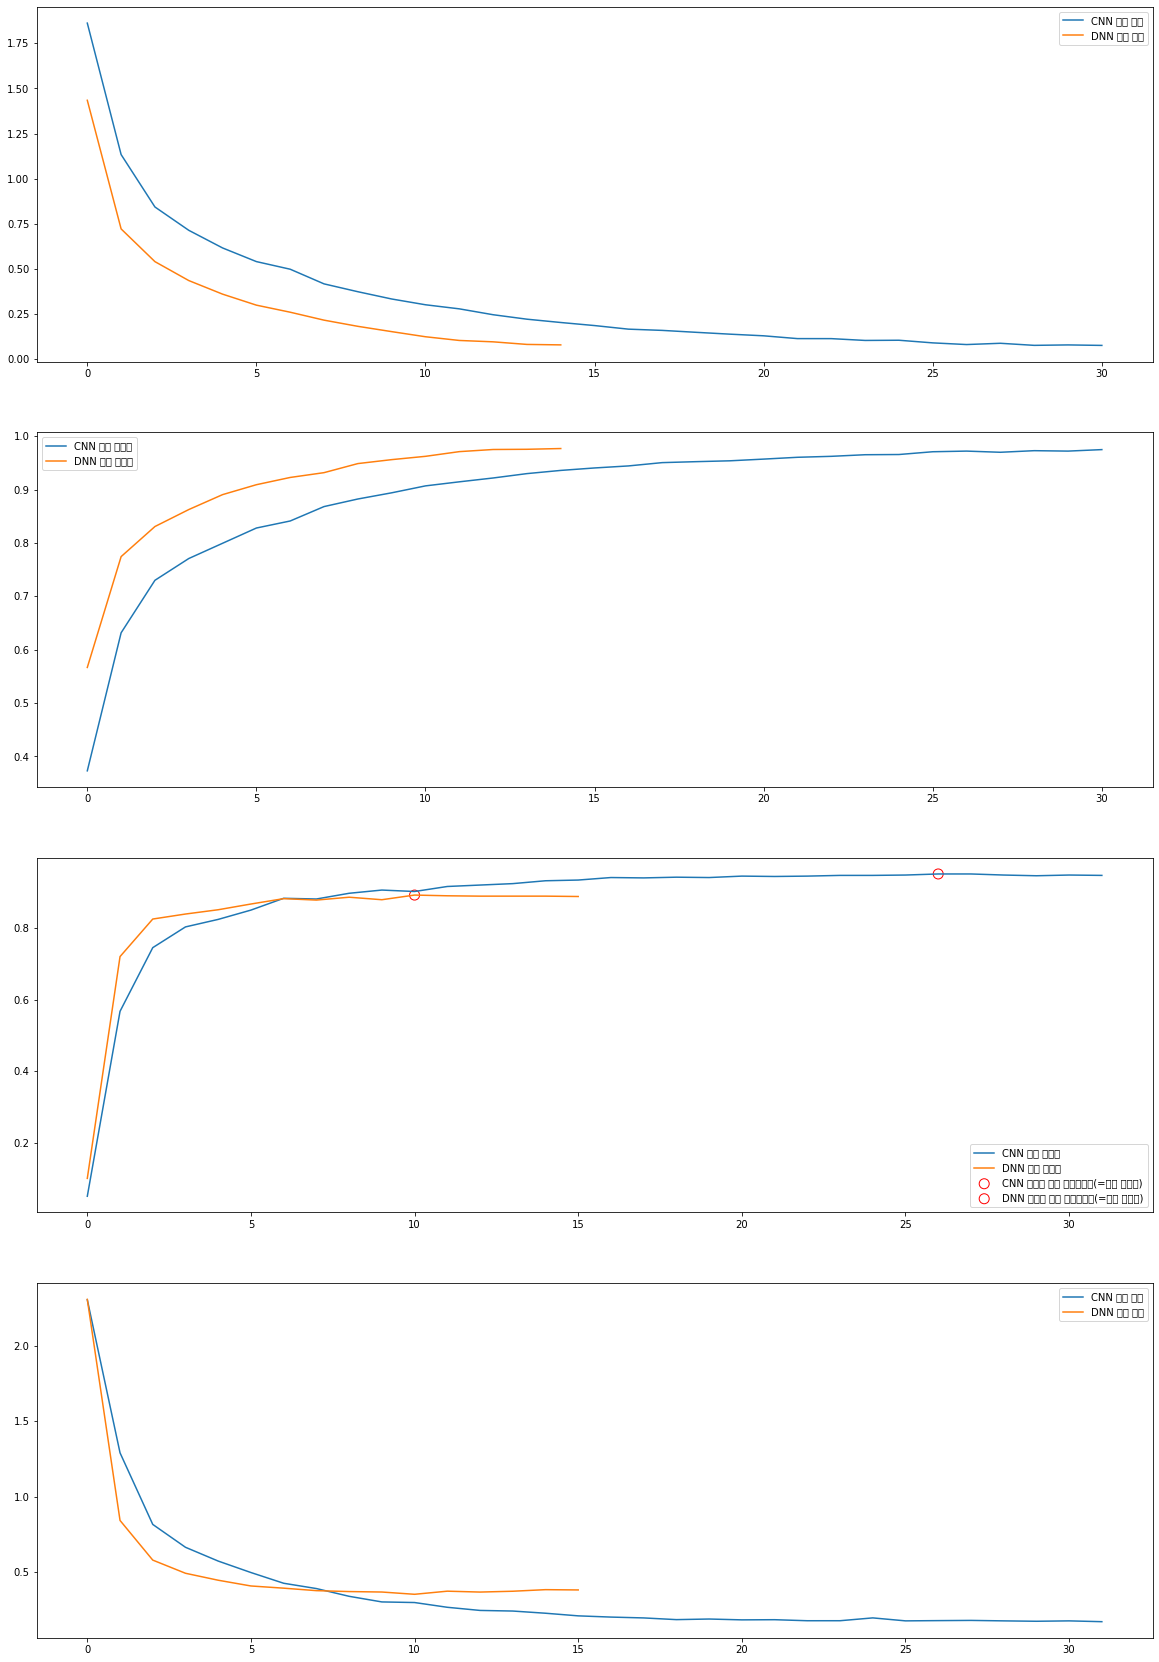

In [50]:
# CNN logs
cnn_train_loss = cnn.train_loss_
cnn_train_acc = cnn.train_acc_
cnn_valid_loss = cnn.val_loss_
cnn_valid_acc = cnn.val_acc_

#DNN logs
dnn_train_loss = dnn.train_loss_
dnn_train_acc = dnn.train_acc_
dnn_valid_loss = dnn.val_loss_
dnn_valid_acc = dnn.val_acc_

#그래프 배경화면 만들기
f, axs = plt.subplots(4,1,figsize=(20,30))

#학습로스 변동 관찰하기
axs[0].plot(cnn_train_loss,label='CNN 학습 로스')
axs[0].plot(dnn_train_loss,label='DNN 학습 로스')
axs[0].legend()

#학습 정확도 변동 관찰하기
axs[1].plot(cnn_train_acc,label='CNN 학습 정확도')
axs[1].plot(dnn_train_acc,label='DNN 학습 정확도')
axs[1].legend()

#검증용 데이터에 대한 accuracy 변동 관찰하기
axs[2].plot(cnn_valid_acc,label='CNN 검증 정확도')
axs[2].scatter(np.argmax(cnn_valid_acc),np.max(cnn_valid_acc),s=100,facecolors='none',edgecolors='r',label='CNN 최적의 학습 체크포인트(=학습 중단점)')
axs[2].plot(dnn_valid_acc,label='DNN 검증 정확도')
axs[2].scatter(np.argmax(dnn_valid_acc),np.max(dnn_valid_acc),s=100,facecolors='none',edgecolors='r',label='DNN 최적의 학습 체크포인트(=학습 중단점)')
axs[2].legend()

#검증용 데이터에 대한 loss 변동 관찰하기
axs[3].plot(cnn_valid_loss,label='CNN 검증 로스')
axs[3].plot(dnn_valid_loss,label='DNN 검증 로스')
axs[3].legend()

plt.show()

In [49]:
np.argmax(cnn_valid_acc), np.argmax(dnn_valid_acc)

(26, 10)

In [47]:
# Test accuracy 확인

trainer.test(model=cnn, dataloaders=test_loader)
trainer.test(model=dnn, dataloaders=test_loader)

cnn_test_accuracy = accuracy_score(y_pred=cnn.test_predicted.argmax(1),y_true=cnn.test_target)
dnn_test_accuracy = accuracy_score(y_pred=dnn.test_predicted.argmax(1),y_true=dnn.test_target)
print(f"CNN 분류 정확도: {cnn_test_accuracy:.3f}",f"DNN 분류 정확도: {dnn_test_accuracy:.3f}",sep=' l ')

Testing: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

CNN 분류 정확도: 0.880 l DNN 분류 정확도: 0.809


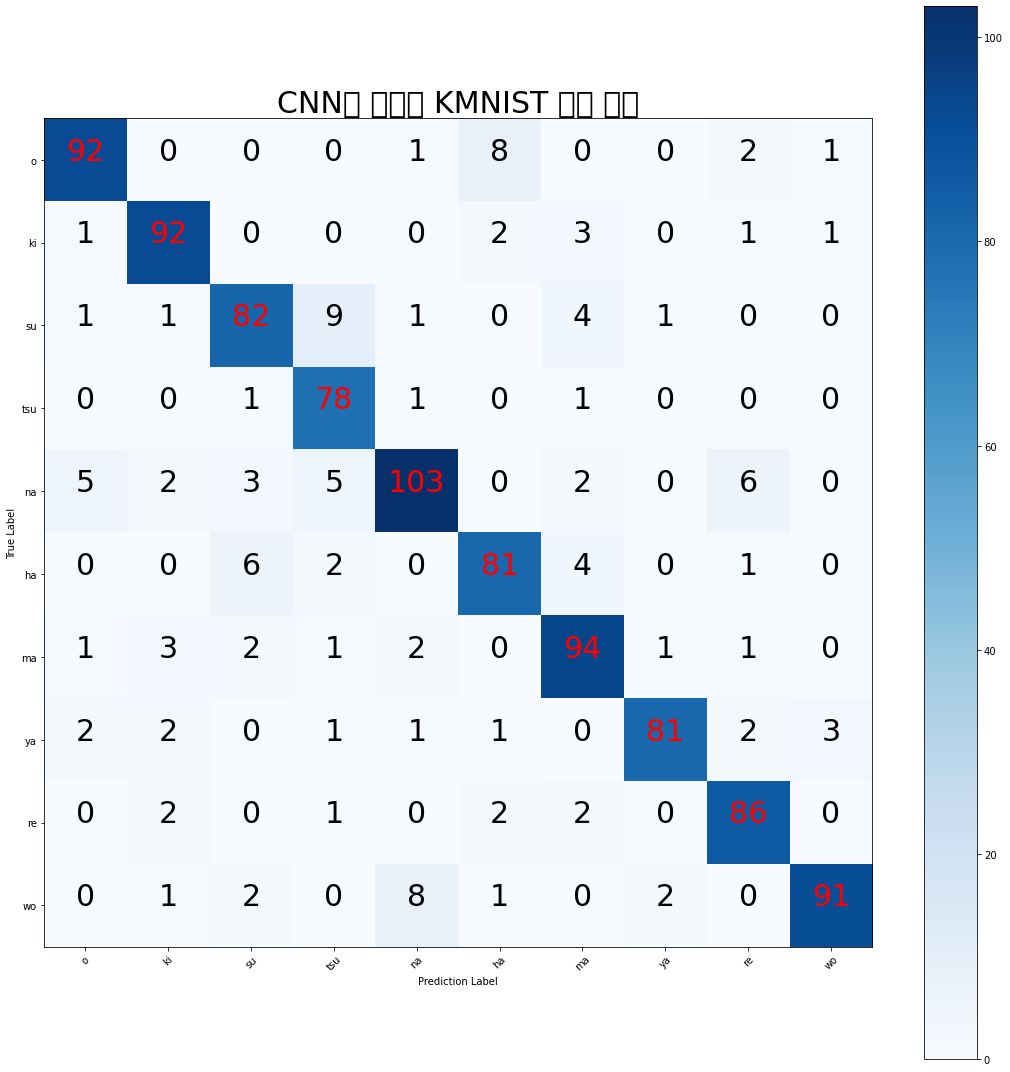

In [48]:
confusion_matrix_ = confusion_matrix(y_pred=cnn.test_predicted.argmax(1),y_true=cnn.test_target)
plot_confusion_matrix(cm = confusion_matrix_, classes=dataset.classes,title='CNN을 이용한 KMNIST 예측 결과')

In [29]:
class CNN(pl.LightningModule):
    def __init__(self, class_num):
        super().__init__()
        
        #convolution
        self.conv1 = nn.Conv2d(1,10,(3,3))
        self.conv2 = nn.Conv2d(10,20,(3,3))
        self.conv3 = nn.Conv2d(20,20,(3,3))
        
        #pooling layer
        self.max_pool = nn.MaxPool2d((2,2),2)
        
        #dropout
        self.dropout_1 = nn.Dropout(p=0.3)
        self.dropout_2 = nn.Dropout(p=0.1)
        
        #activation function
        self.relu = nn.ReLU(inplace=True)
        self.lrelu = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        
        #classifier
        self.classifier = nn.Sequential(nn.Linear(500, 300),
                                       self.relu,
                                       self.dropout_1,
                                       nn.Linear(300,100),
                                       self.lrelu,
                                       self.dropout_2,
                                       nn.Linear(100, class_num))
        
        #for logging
        self.train_loss_ = []
        self.train_acc_ = []
        self.val_loss_ = []
        self.val_acc_ = []
        
        #for convenient
        self.class_num = class_num
        
    def forward(self, x): #x is input data
        
        # x -> convolution -> relu -> max_pool -> dropout
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool(x)
        x = self.dropout_1(x)
        
        # .. -> convolution -> relu -> max_pool -> dropout
        x = self.conv2(x)
        x = self.lrelu(x)
        x = self.max_pool(x)
        x = self.dropout_2(x)
        
        # .. -> classifier - logit
        flatten = x.view(x.size(0),-1)
        logit = self.classifier(flatten)
        
        return logit
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters() , lr = 0.001)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logit = self(x)
        prob = F.softmax(logit, dim=1)
        train_accuracy = FM.accuracy(prob,y)
        loss = F.cross_entropy(logit,y)
        logs = {'train_loss':loss, 'train_acc':train_accuracy}
        result = {'loss':loss, 'log':logs, 'train_acc':train_accuracy}
        return result
    
    def training_epoch_end(self,result):
        avg_loss = torch.stack([x['loss'] for x in result]).mean()
        avg_acc = torch.stack([x['train_acc'] for x in result]).mean()
        global cn_train_epoch_result
        cn_train_epoch_result = {'loss': avg_loss, 'train_acc': avg_acc}
        self.train_loss_.append(avg_loss.cpu().numpy().item())
        self.train_acc_.append(avg_acc.cpu().numpy().item())
        
    
    def validation_step(self,batch,batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat_prob = F.softmax(y_hat,dim=1)
        val_accuracy = FM.accuracy(y_hat_prob,y)
        val_loss = F.cross_entropy(y_hat,y)
        logs = {'val_accuracy':val_accuracy,'val_loss':val_loss}
        result = {'loss':val_loss,'log':logs,'val_acc':val_accuracy}
        return result
    
    def validation_epoch_end(self,result):
        avg_loss = torch.stack([x['loss'] for x in result]).mean()
        avg_acc = torch.stack([x['val_acc'] for x in result]).mean()
        epoch_result = {'loss':avg_loss,'acc':avg_acc}
        self.val_loss_.append(avg_loss.cpu().numpy().item())
        self.val_acc_.append(avg_acc.cpu().numpy().item())
        self.log('val_accuracy',avg_acc)
        return epoch_result
    
    def test_step(self,batch,batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat_prob = F.softmax(y_hat,dim=1)
        result = {'predicted':y_hat_prob,'target':y}
        return result
    
    def test_epoch_end(self,result):
        
        predicted = torch.stack([x['predicted'] for x in result])
        predicted = predicted.view(-1,self.class_num)
        target = torch.stack([x['target'] for x in result])
        target = target.view(-1)
        
        self.test_predicted = predicted.detach().cpu().numpy()
        self.test_target = target.detach().cpu().numpy()

In [30]:
class DNN(pl.LightningModule):
    def __init__(self, class_num):
        super().__init__()
        
        #dropout
        self.dropout_1 = nn.Dropout(p=0.3)
        self.dropout_2 = nn.Dropout(p=0.1)
        
        #activation function
        self.relu = nn.ReLU(inplace=True)
        self.lrelu = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        
        #classifier
        self.classifier = nn.Sequential(nn.Linear(28*28, 300),
                                       self.relu,
                                       self.dropout_1,
                                       nn.Linear(300,100),
                                       self.lrelu,
                                       self.dropout_2,
                                       nn.Linear(100, class_num))
        
        #for logging
        self.train_loss_ = []
        self.train_acc_ = []
        self.val_loss_ = []
        self.val_acc_ = []
        
        #for convenient
        self.class_num = class_num
        
    def forward(self, x): #x is input data
        
        # .. -> classifier - logit
        flatten = x.view(x.size(0),-1)
        logit = self.classifier(flatten)
        
        return logit
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters() , lr = 0.001)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logit = self(x)
        prob = F.softmax(logit, dim=1)
        train_accuracy = FM.accuracy(prob,y)
        loss = F.cross_entropy(logit,y)
        logs = {'train_loss':loss, 'train_acc':train_accuracy}
        result = {'loss':loss, 'log':logs, 'train_acc':train_accuracy}
        return result
    
    def training_epoch_end(self,result):
        avg_loss = torch.stack([x['loss'] for x in result]).mean()
        avg_acc = torch.stack([x['train_acc'] for x in result]).mean()
        global dn_train_epoch_result
        dn_train_epoch_result = {'loss': avg_loss, 'train_acc': avg_acc}
        self.train_loss_.append(avg_loss.cpu().numpy().item())
        self.train_acc_.append(avg_acc.cpu().numpy().item())
    
    def validation_step(self,batch,batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat_prob = F.softmax(y_hat,dim=1)
        val_accuracy = FM.accuracy(y_hat_prob,y)
        val_loss = F.cross_entropy(y_hat,y)
        logs = {'val_accuracy':val_accuracy,'val_loss':val_loss}
        result = {'loss':val_loss,'log':logs,'val_acc':val_accuracy}
        return result
    
    def validation_epoch_end(self,result):
        avg_loss = torch.stack([x['loss'] for x in result]).mean()
        avg_acc = torch.stack([x['val_acc'] for x in result]).mean()
        epoch_result = {'loss': avg_loss,'acc': avg_acc}
        self.val_loss_.append(avg_loss.cpu().numpy().item())
        self.val_acc_.append(avg_acc.cpu().numpy().item())
        self.log('val_accuracy',avg_acc)
        return epoch_result
    
    def test_step(self,batch,batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat_prob = F.softmax(y_hat,dim=1)
        result = {'predicted':y_hat_prob,'target':y}
        return result
    
    def test_epoch_end(self,result):
        
        predicted = torch.stack([x['predicted'] for x in result])
        predicted = predicted.view(-1,self.class_num)
        target = torch.stack([x['target'] for x in result])
        target = target.view(-1)
        
        self.test_predicted = predicted.detach().cpu().numpy()
        self.test_target = target.detach().cpu().numpy()
        

In [31]:
start = time.time()
cnn = CNN(class_num=10)
early_stop = EarlyStopping(monitor='val_accuracy',patience=5,verbose=True,mode='max') #Early stopping
checkpoint = ModelCheckpoint(filename='./CNN-{epoch}-{val_accuracy}',monitor='val_accuracy',mode='max',save_top_k=1) #mode
trainer = pl.Trainer(callbacks=[early_stop,checkpoint],gpus=0)
trainer.fit(cnn,train_loader,valid_loader)
print("time :", time.time() - start) #학습소요시간 출력

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | conv1      | Conv2d     | 100   
1 | conv2      | Conv2d     | 1.8 K 
2 | conv3      | Conv2d     | 3.6 K 
3 | max_pool   | MaxPool2d  | 0     
4 | dropout_1  | Dropout    | 0     
5 | dropout_2  | Dropout    | 0     
6 | relu       | ReLU       | 0     
7 | lrelu      | LeakyReLU  | 0     
8 | classifier | Sequential | 181 K 
------------------------------------------
186 K     Trainable params
0         Non-trainable params
186 K     Total params
0.748     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved. New best score: 0.643


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.096 >= min_delta = 0.0. New best score: 0.739


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.071 >= min_delta = 0.0. New best score: 0.810


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.033 >= min_delta = 0.0. New best score: 0.843


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.016 >= min_delta = 0.0. New best score: 0.859


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.032 >= min_delta = 0.0. New best score: 0.891


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.895


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.016 >= min_delta = 0.0. New best score: 0.911


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.005 >= min_delta = 0.0. New best score: 0.916


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.014 >= min_delta = 0.0. New best score: 0.930


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.008 >= min_delta = 0.0. New best score: 0.938


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.006 >= min_delta = 0.0. New best score: 0.944


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_accuracy did not improve in the last 5 records. Best score: 0.944. Signaling Trainer to stop.


time : 118.59911918640137


In [32]:
start = time.time()
dnn = DNN(class_num=10)
early_stop = EarlyStopping(monitor='val_accuracy',patience=5,verbose=True,mode='max') #Early stopping
checkpoint = ModelCheckpoint(filename='./DNN-{epoch}-{val_accuracy}',monitor='val_accuracy',mode='max',save_top_k=1) #mode
trainer = pl.Trainer(callbacks=[early_stop,checkpoint],gpus=0)
trainer.fit(dnn,train_loader,valid_loader)
print("time :", time.time() - start) #학습소요시간 출력

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | dropout_1  | Dropout    | 0     
1 | dropout_2  | Dropout    | 0     
2 | relu       | ReLU       | 0     
3 | lrelu      | LeakyReLU  | 0     
4 | classifier | Sequential | 266 K 
------------------------------------------
266 K     Trainable params
0         Non-trainable params
266 K     Total params
1.066     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved. New best score: 0.752


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.063 >= min_delta = 0.0. New best score: 0.815


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.029 >= min_delta = 0.0. New best score: 0.844


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.017 >= min_delta = 0.0. New best score: 0.861


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.010 >= min_delta = 0.0. New best score: 0.871


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.006 >= min_delta = 0.0. New best score: 0.877


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.005 >= min_delta = 0.0. New best score: 0.882


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.885


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.006 >= min_delta = 0.0. New best score: 0.891


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.008 >= min_delta = 0.0. New best score: 0.899


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.903


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.904


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_accuracy did not improve in the last 5 records. Best score: 0.904. Signaling Trainer to stop.


time : 63.500138998031616


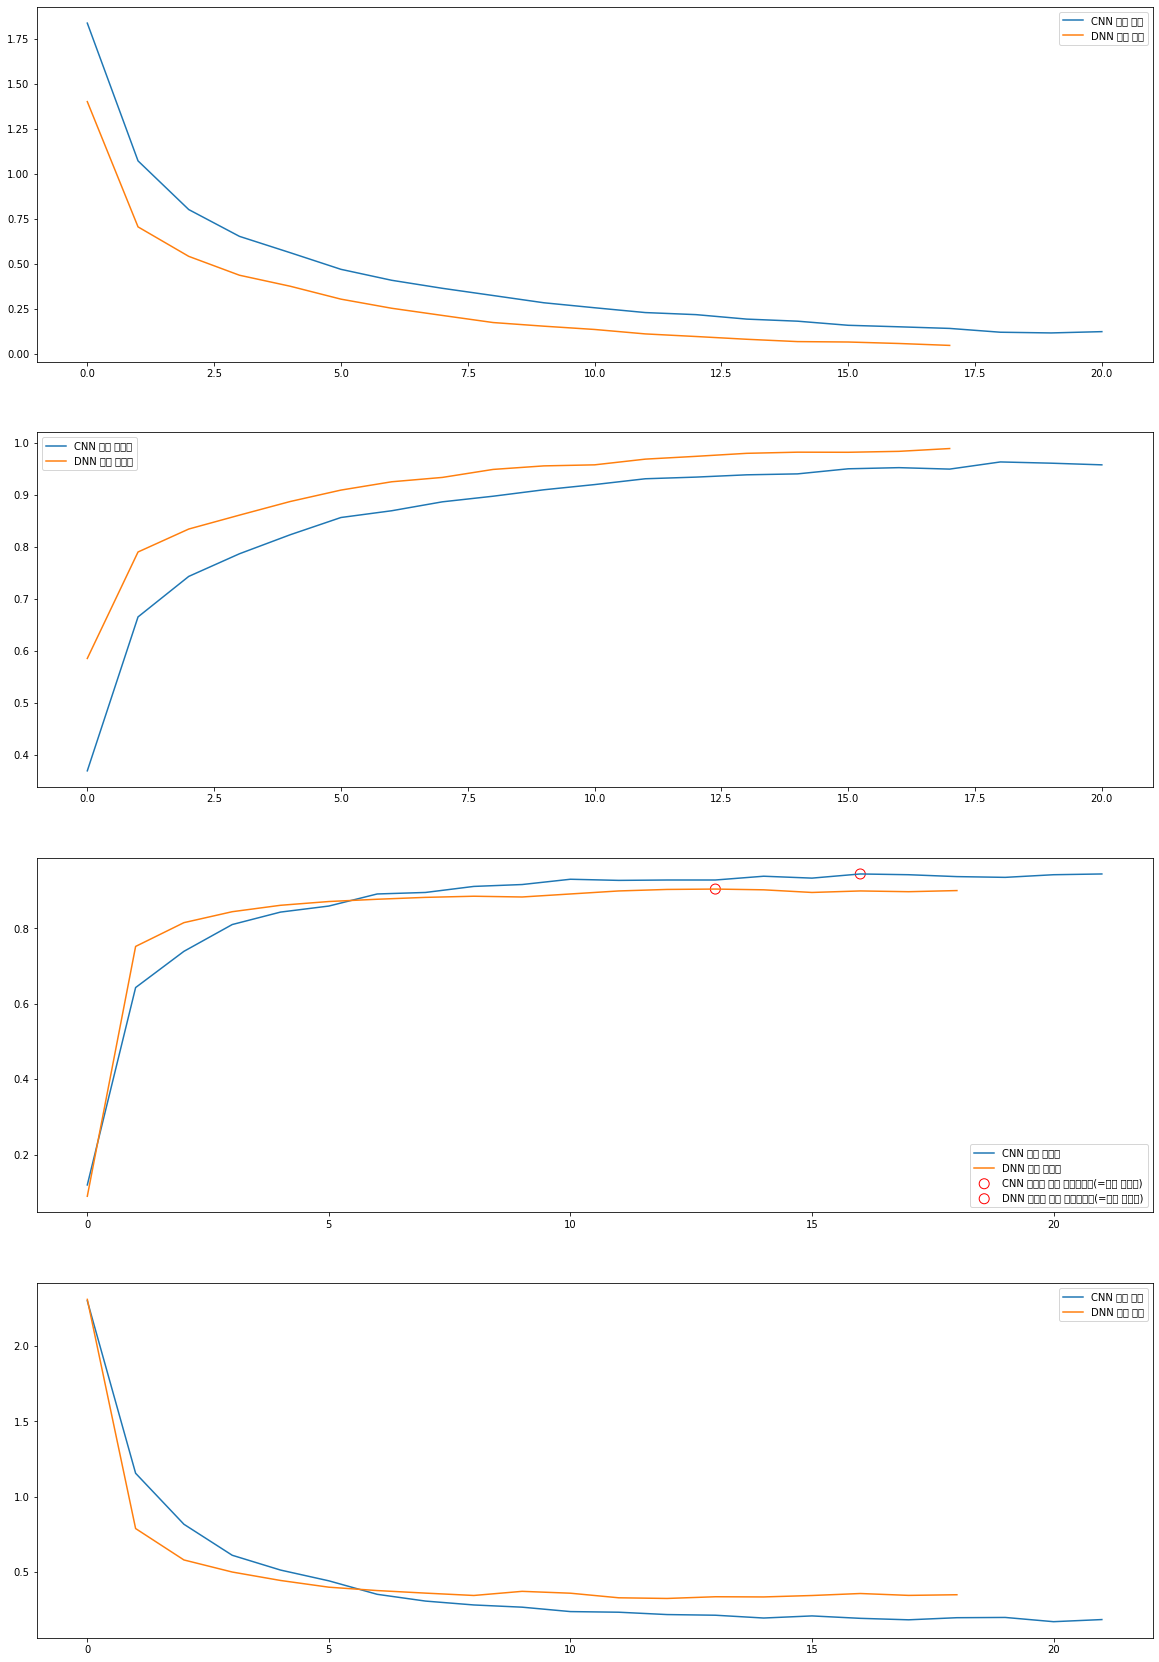

In [33]:
# CNN logs
cnn_train_loss = cnn.train_loss_
cnn_train_acc = cnn.train_acc_
cnn_valid_loss = cnn.val_loss_
cnn_valid_acc = cnn.val_acc_

#DNN logs
dnn_train_loss = dnn.train_loss_
dnn_train_acc = dnn.train_acc_
dnn_valid_loss = dnn.val_loss_
dnn_valid_acc = dnn.val_acc_

#그래프 배경화면 만들기
f, axs = plt.subplots(4,1,figsize=(20,30))

#학습로스 변동 관찰하기
axs[0].plot(cnn_train_loss,label='CNN 학습 로스')
axs[0].plot(dnn_train_loss,label='DNN 학습 로스')
axs[0].legend()

#학습 정확도 변동 관찰하기
axs[1].plot(cnn_train_acc,label='CNN 학습 정확도')
axs[1].plot(dnn_train_acc,label='DNN 학습 정확도')
axs[1].legend()

#검증용 데이터에 대한 accuracy 변동 관찰하기
axs[2].plot(cnn_valid_acc,label='CNN 검증 정확도')
axs[2].scatter(np.argmax(cnn_valid_acc),np.max(cnn_valid_acc),s=100,facecolors='none',edgecolors='r',label='CNN 최적의 학습 체크포인트(=학습 중단점)')
axs[2].plot(dnn_valid_acc,label='DNN 검증 정확도')
axs[2].scatter(np.argmax(dnn_valid_acc),np.max(dnn_valid_acc),s=100,facecolors='none',edgecolors='r',label='DNN 최적의 학습 체크포인트(=학습 중단점)')
axs[2].legend()

#검증용 데이터에 대한 loss 변동 관찰하기
axs[3].plot(cnn_valid_loss,label='CNN 검증 로스')
axs[3].plot(dnn_valid_loss,label='DNN 검증 로스')
axs[3].legend()

plt.show()

In [34]:
np.argmax(cnn_valid_acc), np.argmax(dnn_valid_acc)

(16, 13)

In [35]:
# Test accuracy 확인

trainer.test(model=cnn, dataloaders=test_loader)
trainer.test(model=dnn, dataloaders=test_loader)

cnn_test_accuracy = accuracy_score(y_pred=cnn.test_predicted.argmax(1),y_true=cnn.test_target)
dnn_test_accuracy = accuracy_score(y_pred=dnn.test_predicted.argmax(1),y_true=dnn.test_target)
print(f"CNN 분류 정확도: {cnn_test_accuracy:.3f}",f"DNN 분류 정확도: {dnn_test_accuracy:.3f}",sep=' l ')

Testing: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

CNN 분류 정확도: 0.865 l DNN 분류 정확도: 0.790


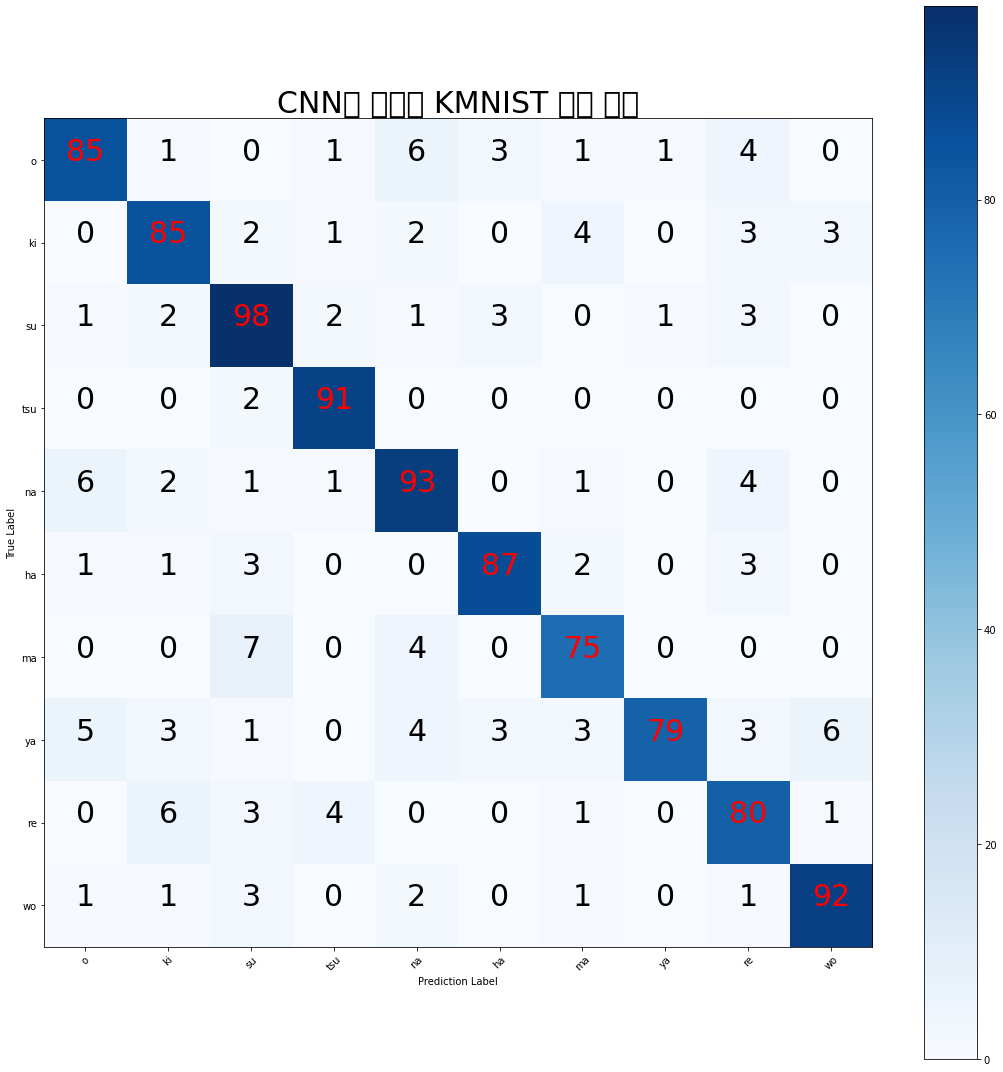

In [36]:
confusion_matrix_ = confusion_matrix(y_pred=cnn.test_predicted.argmax(1),y_true=cnn.test_target)
plot_confusion_matrix(cm = confusion_matrix_, classes=dataset.classes,title='CNN을 이용한 KMNIST 예측 결과')

In [37]:
class CNN(pl.LightningModule):
    def __init__(self, class_num):
        super().__init__()
        
        #convolution
        self.conv1 = nn.Conv2d(1,10,(3,3))
        self.conv2 = nn.Conv2d(10,20,(3,3))
        self.conv3 = nn.Conv2d(20,40,(5,5))
        
        #pooling layer
        self.max_pool = nn.MaxPool2d((2,2),2)
        
        #dropout
        self.dropout_1 = nn.Dropout(p=0.3)
        self.dropout_2 = nn.Dropout(p=0.1)
        
        #activation function
        self.relu = nn.ReLU(inplace=True)
        self.lrelu = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        
        #classifier
        self.classifier = nn.Sequential(nn.Linear(500, 300),
                                       self.relu,
                                       self.dropout_1,
                                       nn.Linear(300,100),
                                       self.lrelu,
                                       self.dropout_2,
                                       nn.Linear(100, class_num))
        
        #for logging
        self.train_loss_ = []
        self.train_acc_ = []
        self.val_loss_ = []
        self.val_acc_ = []
        
        #for convenient
        self.class_num = class_num
        
    def forward(self, x): #x is input data
        
        # x -> convolution -> relu -> max_pool -> dropout
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool(x)
        x = self.dropout_1(x)
        
        # .. -> convolution -> relu -> max_pool -> dropout
        x = self.conv2(x)
        x = self.lrelu(x)
        x = self.max_pool(x)
        x = self.dropout_2(x)
        
        # .. -> classifier - logit
        flatten = x.view(x.size(0),-1)
        logit = self.classifier(flatten)
        
        return logit
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters() , lr = 0.001)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logit = self(x)
        prob = F.softmax(logit, dim=1)
        train_accuracy = FM.accuracy(prob,y)
        loss = F.cross_entropy(logit,y)
        logs = {'train_loss':loss, 'train_acc':train_accuracy}
        result = {'loss':loss, 'log':logs, 'train_acc':train_accuracy}
        return result
    
    def training_epoch_end(self,result):
        avg_loss = torch.stack([x['loss'] for x in result]).mean()
        avg_acc = torch.stack([x['train_acc'] for x in result]).mean()
        global cn_train_epoch_result
        cn_train_epoch_result = {'loss': avg_loss, 'train_acc': avg_acc}
        self.train_loss_.append(avg_loss.cpu().numpy().item())
        self.train_acc_.append(avg_acc.cpu().numpy().item())
        
    
    def validation_step(self,batch,batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat_prob = F.softmax(y_hat,dim=1)
        val_accuracy = FM.accuracy(y_hat_prob,y)
        val_loss = F.cross_entropy(y_hat,y)
        logs = {'val_accuracy':val_accuracy,'val_loss':val_loss}
        result = {'loss':val_loss,'log':logs,'val_acc':val_accuracy}
        return result
    
    def validation_epoch_end(self,result):
        avg_loss = torch.stack([x['loss'] for x in result]).mean()
        avg_acc = torch.stack([x['val_acc'] for x in result]).mean()
        epoch_result = {'loss':avg_loss,'acc':avg_acc}
        self.val_loss_.append(avg_loss.cpu().numpy().item())
        self.val_acc_.append(avg_acc.cpu().numpy().item())
        self.log('val_accuracy',avg_acc)
        return epoch_result
    
    def test_step(self,batch,batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat_prob = F.softmax(y_hat,dim=1)
        result = {'predicted':y_hat_prob,'target':y}
        return result
    
    def test_epoch_end(self,result):
        
        predicted = torch.stack([x['predicted'] for x in result])
        predicted = predicted.view(-1,self.class_num)
        target = torch.stack([x['target'] for x in result])
        target = target.view(-1)
        
        self.test_predicted = predicted.detach().cpu().numpy()
        self.test_target = target.detach().cpu().numpy()

In [38]:
start = time.time()
cnn = CNN(class_num=10)
early_stop = EarlyStopping(monitor='val_accuracy',patience=5,verbose=True,mode='max') #Early stopping
checkpoint = ModelCheckpoint(filename='./CNN-{epoch}-{val_accuracy}',monitor='val_accuracy',mode='max',save_top_k=1) #mode
trainer = pl.Trainer(callbacks=[early_stop,checkpoint],gpus=0)
trainer.fit(cnn,train_loader,valid_loader)
print("time :", time.time() - start) #학습소요시간 출력

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | conv1      | Conv2d     | 100   
1 | conv2      | Conv2d     | 1.8 K 
2 | conv3      | Conv2d     | 20.0 K
3 | max_pool   | MaxPool2d  | 0     
4 | dropout_1  | Dropout    | 0     
5 | dropout_2  | Dropout    | 0     
6 | relu       | ReLU       | 0     
7 | lrelu      | LeakyReLU  | 0     
8 | classifier | Sequential | 181 K 
------------------------------------------
203 K     Trainable params
0         Non-trainable params
203 K     Total params
0.813     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved. New best score: 0.622


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.124 >= min_delta = 0.0. New best score: 0.746


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.048 >= min_delta = 0.0. New best score: 0.794


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.036 >= min_delta = 0.0. New best score: 0.830


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.021 >= min_delta = 0.0. New best score: 0.851


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.023 >= min_delta = 0.0. New best score: 0.874


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.018 >= min_delta = 0.0. New best score: 0.892


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.012 >= min_delta = 0.0. New best score: 0.904


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.007 >= min_delta = 0.0. New best score: 0.911


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.017 >= min_delta = 0.0. New best score: 0.928


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.006 >= min_delta = 0.0. New best score: 0.934


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.935


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.936


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.939


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.942


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.945


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.946


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.947


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.008 >= min_delta = 0.0. New best score: 0.955


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_accuracy did not improve in the last 5 records. Best score: 0.955. Signaling Trainer to stop.


time : 166.98563742637634


In [39]:
class DNN(pl.LightningModule):
    def __init__(self, class_num):
        super().__init__()
        
        #dropout
        self.dropout_1 = nn.Dropout(p=0.3)
        self.dropout_2 = nn.Dropout(p=0.1)
        
        #activation function
        self.relu = nn.ReLU(inplace=True)
        self.lrelu = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        
        #classifier
        self.classifier = nn.Sequential(nn.Linear(28*28, 300),
                                       self.relu,
                                       self.dropout_1,
                                       nn.Linear(300,100),
                                       self.lrelu,
                                       self.dropout_2,
                                       nn.Linear(100, class_num))
        
        #for logging
        self.train_loss_ = []
        self.train_acc_ = []
        self.val_loss_ = []
        self.val_acc_ = []
        
        #for convenient
        self.class_num = class_num
        
    def forward(self, x): #x is input data
        
        # .. -> classifier - logit
        flatten = x.view(x.size(0),-1)
        logit = self.classifier(flatten)
        
        return logit
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters() , lr = 0.001)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logit = self(x)
        prob = F.softmax(logit, dim=1)
        train_accuracy = FM.accuracy(prob,y)
        loss = F.cross_entropy(logit,y)
        logs = {'train_loss':loss, 'train_acc':train_accuracy}
        result = {'loss':loss, 'log':logs, 'train_acc':train_accuracy}
        return result
    
    def training_epoch_end(self,result):
        avg_loss = torch.stack([x['loss'] for x in result]).mean()
        avg_acc = torch.stack([x['train_acc'] for x in result]).mean()
        global dn_train_epoch_result
        dn_train_epoch_result = {'loss': avg_loss, 'train_acc': avg_acc}
        self.train_loss_.append(avg_loss.cpu().numpy().item())
        self.train_acc_.append(avg_acc.cpu().numpy().item())
    
    def validation_step(self,batch,batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat_prob = F.softmax(y_hat,dim=1)
        val_accuracy = FM.accuracy(y_hat_prob,y)
        val_loss = F.cross_entropy(y_hat,y)
        logs = {'val_accuracy':val_accuracy,'val_loss':val_loss}
        result = {'loss':val_loss,'log':logs,'val_acc':val_accuracy}
        return result
    
    def validation_epoch_end(self,result):
        avg_loss = torch.stack([x['loss'] for x in result]).mean()
        avg_acc = torch.stack([x['val_acc'] for x in result]).mean()
        epoch_result = {'loss': avg_loss,'acc': avg_acc}
        self.val_loss_.append(avg_loss.cpu().numpy().item())
        self.val_acc_.append(avg_acc.cpu().numpy().item())
        self.log('val_accuracy',avg_acc)
        return epoch_result
    
    def test_step(self,batch,batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat_prob = F.softmax(y_hat,dim=1)
        result = {'predicted':y_hat_prob,'target':y}
        return result
    
    def test_epoch_end(self,result):
        
        predicted = torch.stack([x['predicted'] for x in result])
        predicted = predicted.view(-1,self.class_num)
        target = torch.stack([x['target'] for x in result])
        target = target.view(-1)
        
        self.test_predicted = predicted.detach().cpu().numpy()
        self.test_target = target.detach().cpu().numpy()
        

In [40]:
start = time.time()
dnn = DNN(class_num=10)
early_stop = EarlyStopping(monitor='val_accuracy',patience=5,verbose=True,mode='max') #Early stopping
checkpoint = ModelCheckpoint(filename='./DNN-{epoch}-{val_accuracy}',monitor='val_accuracy',mode='max',save_top_k=1) #mode
trainer = pl.Trainer(callbacks=[early_stop,checkpoint],gpus=0)
trainer.fit(dnn,train_loader,valid_loader)
print("time :", time.time() - start) #학습소요시간 출력

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | dropout_1  | Dropout    | 0     
1 | dropout_2  | Dropout    | 0     
2 | relu       | ReLU       | 0     
3 | lrelu      | LeakyReLU  | 0     
4 | classifier | Sequential | 266 K 
------------------------------------------
266 K     Trainable params
0         Non-trainable params
266 K     Total params
1.066     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved. New best score: 0.745


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.071 >= min_delta = 0.0. New best score: 0.816


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.027 >= min_delta = 0.0. New best score: 0.843


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.012 >= min_delta = 0.0. New best score: 0.855


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.007 >= min_delta = 0.0. New best score: 0.862


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.013 >= min_delta = 0.0. New best score: 0.875


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.009 >= min_delta = 0.0. New best score: 0.884


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.886


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.009 >= min_delta = 0.0. New best score: 0.895


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.899


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.903


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.905


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.908


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.909


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.007 >= min_delta = 0.0. New best score: 0.916


Validation: 0it [00:00, ?it/s]

Metric val_accuracy improved by 0.006 >= min_delta = 0.0. New best score: 0.922


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_accuracy did not improve in the last 5 records. Best score: 0.922. Signaling Trainer to stop.


time : 105.6471221446991


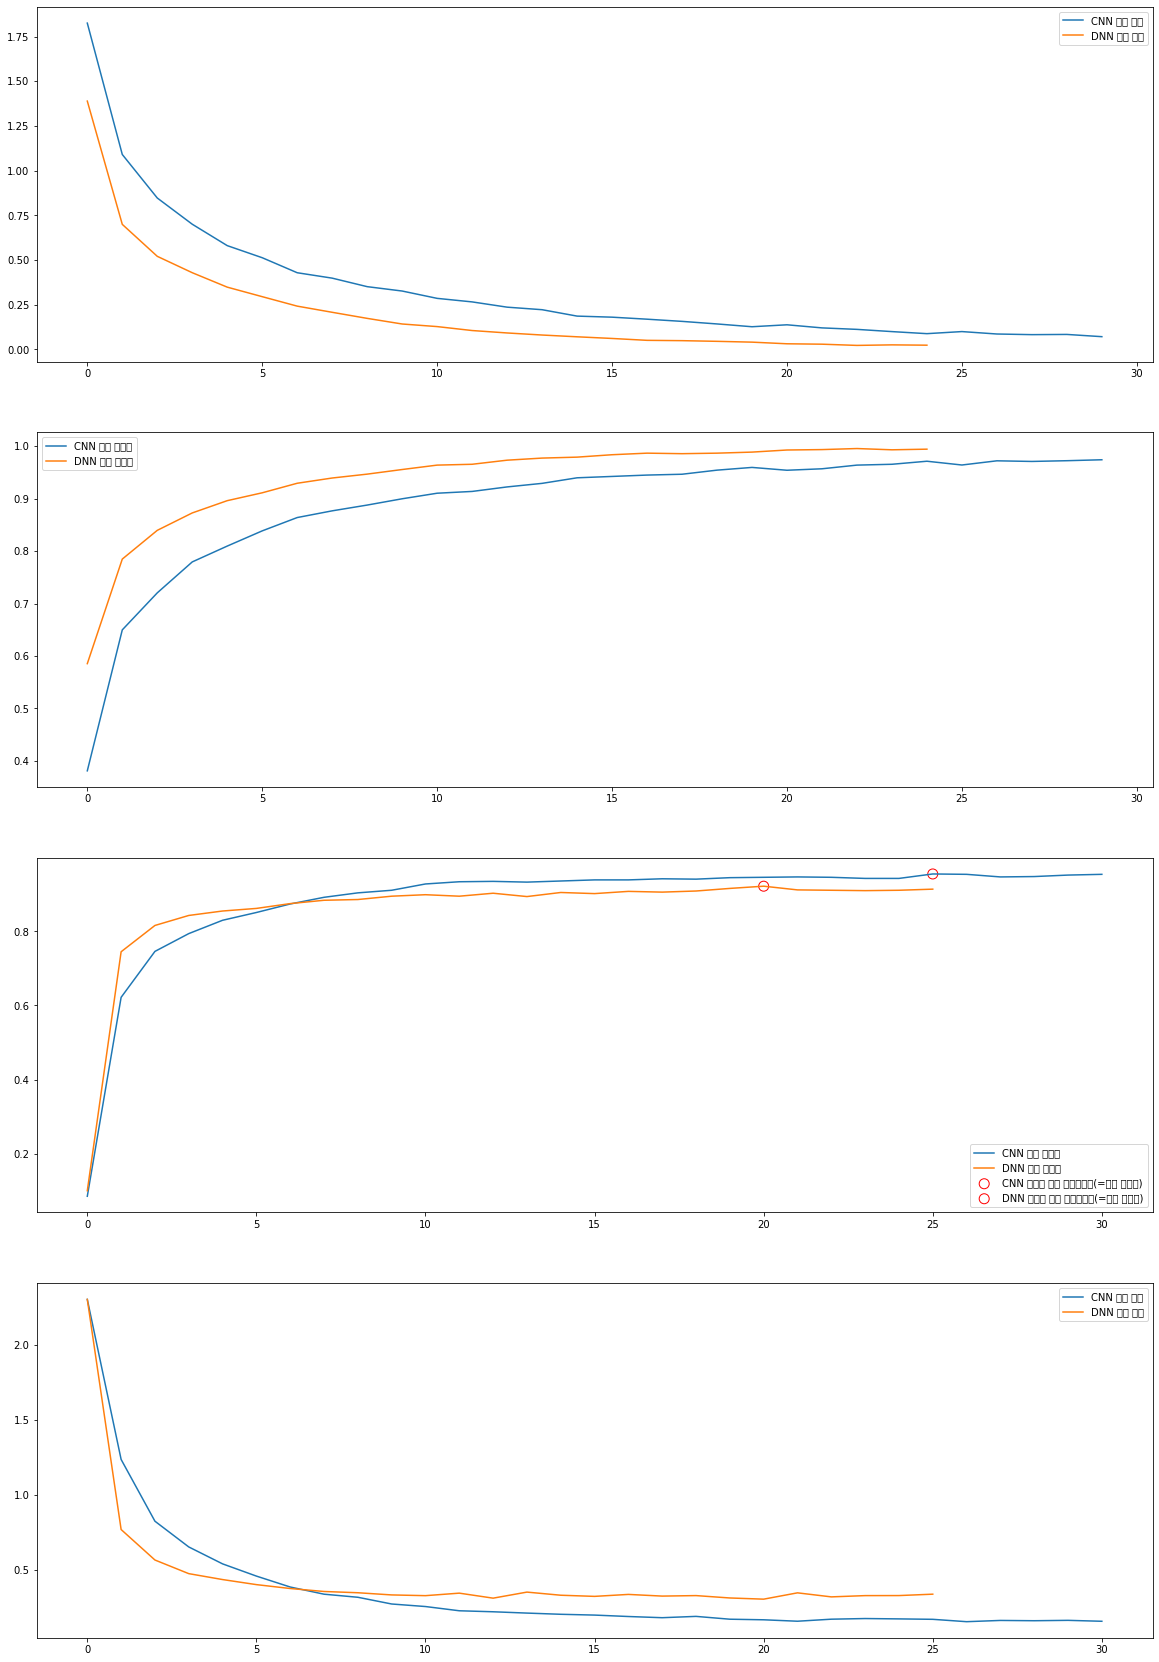

In [41]:
# CNN logs
cnn_train_loss = cnn.train_loss_
cnn_train_acc = cnn.train_acc_
cnn_valid_loss = cnn.val_loss_
cnn_valid_acc = cnn.val_acc_

#DNN logs
dnn_train_loss = dnn.train_loss_
dnn_train_acc = dnn.train_acc_
dnn_valid_loss = dnn.val_loss_
dnn_valid_acc = dnn.val_acc_

#그래프 배경화면 만들기
f, axs = plt.subplots(4,1,figsize=(20,30))

#학습로스 변동 관찰하기
axs[0].plot(cnn_train_loss,label='CNN 학습 로스')
axs[0].plot(dnn_train_loss,label='DNN 학습 로스')
axs[0].legend()

#학습 정확도 변동 관찰하기
axs[1].plot(cnn_train_acc,label='CNN 학습 정확도')
axs[1].plot(dnn_train_acc,label='DNN 학습 정확도')
axs[1].legend()

#검증용 데이터에 대한 accuracy 변동 관찰하기
axs[2].plot(cnn_valid_acc,label='CNN 검증 정확도')
axs[2].scatter(np.argmax(cnn_valid_acc),np.max(cnn_valid_acc),s=100,facecolors='none',edgecolors='r',label='CNN 최적의 학습 체크포인트(=학습 중단점)')
axs[2].plot(dnn_valid_acc,label='DNN 검증 정확도')
axs[2].scatter(np.argmax(dnn_valid_acc),np.max(dnn_valid_acc),s=100,facecolors='none',edgecolors='r',label='DNN 최적의 학습 체크포인트(=학습 중단점)')
axs[2].legend()

#검증용 데이터에 대한 loss 변동 관찰하기
axs[3].plot(cnn_valid_loss,label='CNN 검증 로스')
axs[3].plot(dnn_valid_loss,label='DNN 검증 로스')
axs[3].legend()

plt.show()

In [42]:
np.argmax(cnn_valid_acc), np.argmax(dnn_valid_acc)

(25, 20)

In [43]:
# Test accuracy 확인

trainer.test(model=cnn, dataloaders=test_loader)
trainer.test(model=dnn, dataloaders=test_loader)

cnn_test_accuracy = accuracy_score(y_pred=cnn.test_predicted.argmax(1),y_true=cnn.test_target)
dnn_test_accuracy = accuracy_score(y_pred=dnn.test_predicted.argmax(1),y_true=dnn.test_target)
print(f"CNN 분류 정확도: {cnn_test_accuracy:.3f}",f"DNN 분류 정확도: {dnn_test_accuracy:.3f}",sep=' l ')

Testing: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

CNN 분류 정확도: 0.861 l DNN 분류 정확도: 0.789


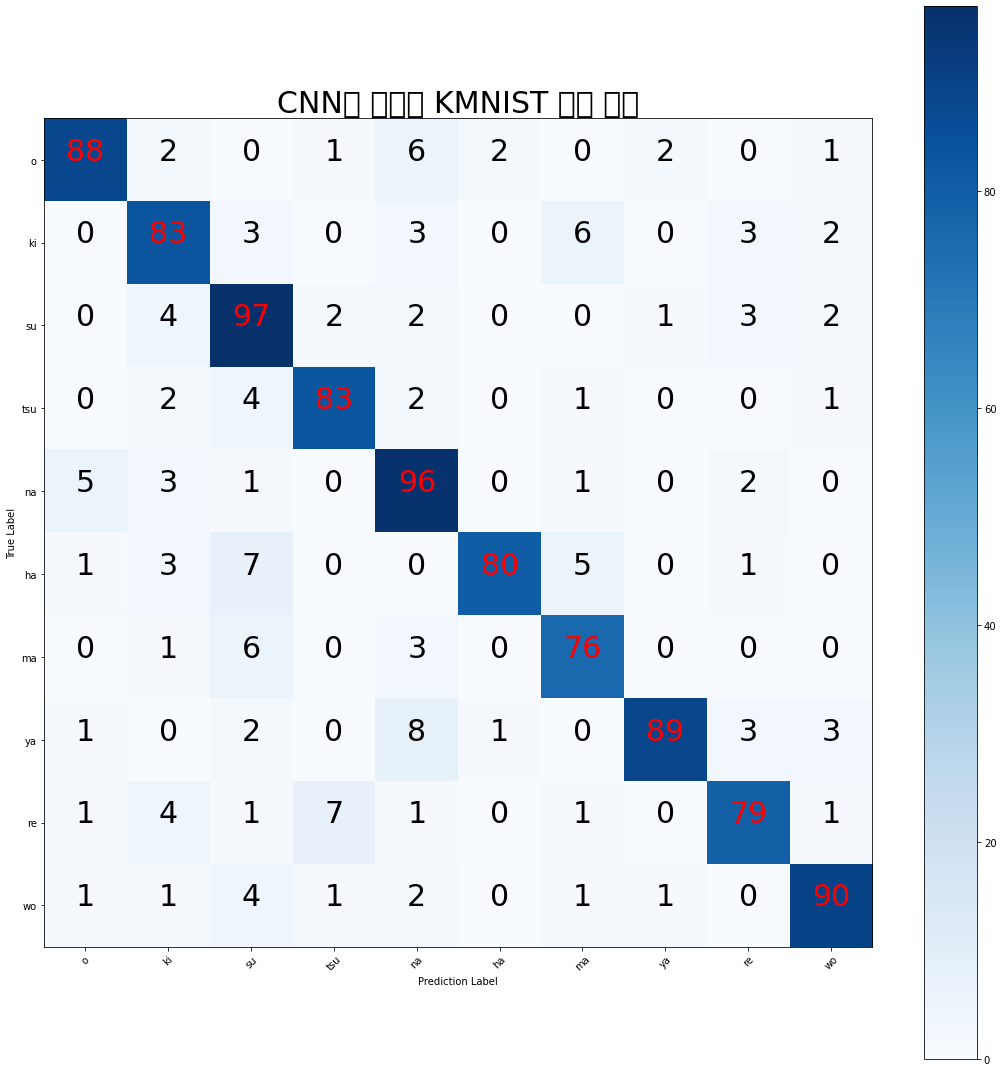

In [44]:
confusion_matrix_ = confusion_matrix(y_pred=cnn.test_predicted.argmax(1),y_true=cnn.test_target)
plot_confusion_matrix(cm = confusion_matrix_, classes=dataset.classes,title='CNN을 이용한 KMNIST 예측 결과')